In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
from scipy import stats
import matplotlib.image as mpimg
from PIL import Image  
Image.MAX_IMAGE_PIXELS = None
# import cv2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from scipy.stats import linregress
from sklearn.neighbors import NearestNeighbors

import anndata as ad
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [3]:
imageSizes={}
imageSizes['disease13']=(22210, 22344)
imageSizes['control13']=(22355, 18953)
imageSizes['disease8']=(22294, 19552)
imageSizes['control8']=(22452, 19616)

plaqueMaskName='PlaqueMask6'
plaqueMaskImg='Maskofplaque6.tif'
lossThreshSize=1111
hiddendim=5000

In [4]:
#load joint

datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

os.environ["CUDA_VISIBLE_DEVICES"] = "3" 

use_cuda=True
fastmode=False #Validate during training pass
batchsize=32
seed=3
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*25*25
fc_dim2=5000
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128

model_str='cnn_vae'
targetBatch=None
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.5)
plotepoch=36
name='cd13_thresh25_02'
modelsavepath='/mnt/external_ssd/xinyi/models/train_jointGAEcnn_starmap/'+name

#Load data
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

# Create model
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE_hook(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
if model_str=='cnn_vae_alexnet':
    modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    
if use_cuda:
    modelcnn.cuda()    
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(plotepoch)+'.pt')))



<All keys matched successfully>

In [5]:
gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)

plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

gaeCoord=None
sampleNames=None
celltype_broad=None
celltype_sub=None
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
for s in plot_samples.keys():
    sampleidx_s=plot_samples[s] 
    if gaeCoord is None:
        gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
        sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
        celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()
        celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()
    else:
        gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
        sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
        celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()))
        celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()))
celltype_broad=celltype_broad.flatten()
gaeCoord=(gaeCoord/0.3).astype(int)
scaleddata=None

modelcnn.eval()

# #compute embeddings
# mulist={}
# labellist={}

# for s in plot_samples.keys():
#     training_samples_t=s
#     if 'disease' in s:
#         plaqueMaskImg_s=plaqueMaskImg
#     elif 'control' in s:
#         plaqueMaskImg_s=None
#     imgInputnp,labellist[s]=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,gaeCoord[sampleNames==training_samples_t],plot_samples[training_samples_t],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
#     muplot_all=np.zeros((imgInputnp.shape[0],hiddendim))
#     for i in range(int(np.ceil(imgInputnp.shape[0]/batchsize))):
#         idx=np.arange(imgInputnp.shape[0])[i*batchsize:min((i+1)*batchsize,imgInputnp.shape[0])]
#         imgInput=imgInputnp[idx]
#         if use_cuda:
#             imgInput=torch.tensor(imgInput).cuda().float()
#         recon,z, mu, logvar = modelcnn(imgInput)

#         mu=mu.cpu().detach().numpy()
# #             if plotRecon:
# #                 if plotRecon=='meanRecon':
# #                     mu=features_recon[3].cpu().detach().numpy()
#         muplot_all[idx]=mu
#     mulist[s]=muplot_all
#     imgInputnp=None

CNN_VAE_hook(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(96, eps=1e-05, 

In [6]:
model_str='fc_regrs3'
fc_dim1=1024
fc_dim2=1024
fc_dim3=1024
testepoch=1250
name='cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01'
modelsavepath='/mnt/external_ssd/xinyi/models/train_regrsFromJoint_starmap/'+name
plotsavepath=os.path.join('/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/'+name,'allk20XA_02_dca_over_leiden0.1_epoch9990_3dseg')
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)
if model_str=='fc_regrs3':
    model = modelsCNN.FC_l3(hiddendim,fc_dim1,fc_dim2,fc_dim3,1,0.5,regrs=False)
    lossCE=torch.nn.MSELoss(reduction='none')
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
if use_cuda:
    model.cuda()

In [7]:
cropsize=200
minmaxsize=400
plotclusters=['0','1','3']
stats3d={}
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     if s!='disease13':
#         continue
    with open('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/stats/'+s+'/'+'stats','rb') as outputseg:
        stats3d[s]=pickle.load(outputseg)

In [8]:
def plotExprs(exprs,exprs2,savename,embedding,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprs is None:
        plt.scatter(embedding[:,0],embedding[:,1],s=5,c=exprs,cmap='Greys',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
    plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=400)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [9]:
def plotExprsDiff(exprsPos,exprsNeg,exprs2,savename,embeddingPos,embeddingNeg,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprsPos is None:
        plt.scatter(embeddingPos[:,0],embeddingPos[:,1],s=5,c=exprsPos,cmap='Reds',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    if not exprsNeg is None:
        plt.scatter(embeddingNeg[:,0],embeddingNeg[:,1],s=5,c=exprsNeg,cmap=plt.cm.get_cmap('Blues'),edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=1200)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [10]:
# lossCE_binary=torch.nn.CrossEntropyLoss(reduction='none')
saveNoCTname=True
saveWithCTname=False

relulayer=torch.nn.ReLU()
np.random.seed(seed)
nPlots=15
minPt=0
savenameAdd='_thresh1111'
# savenameAdd='_thresh4445'
lossThreshSize=1111
def plotLoss(imgNp,inputNp,labelsNp,coordNp,celltypeNp,name,plotsavepath,savenameAdd=''):
    if not os.path.exists(plotsavepath):
        os.mkdir(plotsavepath)
    
    loss_test_all=np.zeros(inputNp.shape[0])
    loss_test_all_binary=np.zeros(inputNp.shape[0])
    loss_test_all_diff=np.zeros(inputNp.shape[0])
#     print(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[i]
        labels=labelsNp[[i]]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        pred = model(testInput)
        pred=relulayer(pred)
        loss_test_all[i]=lossCE(pred.flatten(),labels).item()
#         print(pred)
#         print(labels)
#         if pred[0]*labels[0]>0: 
        if labels[0]>0 and pred[0]>lossThreshSize:
            loss_test_all_binary[i]=0
#         elif pred[0]+labels[0]>0.001: #original
        elif pred[0]>lossThreshSize or labels[0]>0:
            loss_test_all_binary[i]=1
        else:
            loss_test_all_binary[i]=0
        loss_test_all_diff[i]=pred.flatten()[0]-labels[0]
        
    posidx=(labelsNp>0)
    negidx=labelsNp==0
    loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
    loss_test_negLoss=np.sum(loss_test_all[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive: {:.4f}'.format(loss_test_posLoss),
         'loss negative: {:.4f}'.format(loss_test_negLoss))
    
    largeridx=np.logical_and(posidx,loss_test_all_diff>=0)
    smalleridx=np.logical_and(posidx,loss_test_all_diff<0)
    
    plotSampleIdx=np.array([])

    if np.sum(largeridx)>0:
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.xscale('log')
        plt.hist(loss_test_all_diff[largeridx],bins=np.logspace(np.log10(np.min(loss_test_all_diff[largeridx])),np.log10(np.max(loss_test_all_diff[largeridx])),51))
        plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveLarger'+savenameAdd+'.jpg'))
        plt.close()
        plotSampleIdx=np.concatenate((plotSampleIdx,np.random.choice(np.arange(inputNp.shape[0])[largeridx],size=min(nPlots,np.sum(largeridx)),replace=False)))

    if np.sum(smalleridx)>0:
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.xscale('log')
        plt.hist(np.abs(loss_test_all_diff[smalleridx]),bins=np.logspace(np.log10(np.min(np.abs(loss_test_all_diff[smalleridx]))),np.log10(np.max(np.abs(loss_test_all_diff[smalleridx]))),51))
        plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveSmaller'+savenameAdd+'.jpg'))
        plt.close()
        plotSampleIdx=np.concatenate((plotSampleIdx,np.random.choice(np.arange(inputNp.shape[0])[smalleridx],size=min(nPlots,np.sum(smalleridx)),replace=False)))

    if np.sum(negidx)>0:
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.xscale('log')
        plt.hist(loss_test_all_diff[negidx]+0.1,bins=np.logspace(np.log10(np.min(loss_test_all_diff[negidx]+0.1)),np.log10(np.max(loss_test_all_diff[negidx]+0.1)),51))
        plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_negative'+savenameAdd+'.jpg'))
        plt.close()
        plotSampleIdx=np.concatenate((plotSampleIdx,np.random.choice(np.arange(inputNp.shape[0])[negidx],size=min(nPlots*2,np.sum(negidx)),replace=False)))

    if not os.path.exists(os.path.join(plotsavepath,'examples')):
        os.mkdir(os.path.join(plotsavepath,'examples'))
    for idx in plotSampleIdx:
        i=int(idx)
#         if labelsNp[i]==0:
#             continue #skipping negatives
        imgInput=imgNp[[i]]
        if use_cuda:
            imgInput=torch.tensor(imgInput).cuda().float()
        recon,z, mu, logvar = modelcnn(imgInput)

        plotInput=mu
        centroid=coordNp[i]
        plotPlaqueInput=np.zeros_like(imgNp[i][0])
        
        radius=int(diamThresh_mul/2)
        rowstart=int(max(0,centroid[0]-radius))
        rowend=int(min(imageSizes[s][0],centroid[0]+radius))
        colstart=int(max(0,centroid[1]-radius))
        colend=int(min(imageSizes[s][1],centroid[1]+radius))
        if not (plaqueOrigImg is None):
            imagerc=plaqueOrigImg[rowstart:rowend,colstart:colend]
            imagercmin=np.min(imagerc)
            imagercmax=np.max(imagerc)
            if imagercmin==imagercmax:
                print('no plaque')
                imagerc=np.zeros_like(imagerc)
            else:
                imagerc=(imagerc-imagercmin)/(imagercmax-imagercmin)
            plotPlaqueInput[:imagerc.shape[0],:imagerc.shape[1]]=imagerc
        
        if saveWithCTname:
            ctIdx_row=np.logical_and(coordNp[:,0]>=rowstart,coordNp[:,0]<=rowend)
            ctIdx_col=np.logical_and(coordNp[:,1]>=colstart,coordNp[:,1]<=colend)
            ctIdx=np.logical_and(ctIdx_row,ctIdx_col)
            assert np.sum(ctIdx)>0
            ctInRange=celltypeNp[ctIdx]
            ctCoordInRange=coordNp[ctIdx]
        
        gradresult=np.zeros_like(imgNp[i][0])
#         gradinput=inputNp[i]
        predgrad=model(plotInput)
        predgrad.backward()
        gradients = modelcnn.get_activations_gradient()
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        activations = modelcnn.get_activations(imgInput).detach()
        for j in range(activations.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap=heatmap.cpu().numpy()
        
        #for joint only
#         heatmap[:,:3]=np.min(heatmap) #01_rerun
        heatmap[:3,:]=np.min(heatmap[10:,:]) #03
        
        heatmapmin=np.min(heatmap)
        heatmapmax=np.max(heatmap)
        heatmap=(heatmap-heatmapmin)/(heatmapmax-heatmapmin)
        heatmap=Image.fromarray(np.uint8(heatmap*255))
        heatmap = heatmap.resize(((colend-colstart), (rowend-rowstart)), Image.ANTIALIAS)
        gradresult[:(rowend-rowstart),:(colend-colstart)]=np.array(heatmap)/255
        
        imgplotcombined=np.stack((imgNp[i][0],plotPlaqueInput,gradresult),axis=2)
        imgplotcombined_orig=np.copy(imgplotcombined)
        if saveNoCTname:
            fontprops = fm.FontProperties(size=2,family='arial')
            fig, ax = plt.subplots(figsize=(1, 1), dpi=800)
            ax.imshow(imgplotcombined)
            scalebar = AnchoredSizeBar(ax.transData,
                           106, u'10 \u03bcm', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=0.3,
                           fontproperties=fontprops)

            ax.add_artist(scalebar)
            ax.set_yticks([])
            ax.set_xticks([])
            plt.savefig(os.path.join(plotsavepath,'examples',name+s+'pred'+str(loss_test_all_binary[i])+'loss'+str(loss_test_all_diff[i])+'_idx'+str(i)+savenameAdd+'_scalebar.jpg'),dpi=800)
            plt.close()
#             plt.imsave(os.path.join(plotsavepath,'examples',name+s+'pred'+str(loss_test_all_binary[i])+'loss'+str(loss_test_all_diff[i])+'_idx'+str(i)+savenameAdd+'.jpg'),imgplotcombined)            
        
        if saveWithCTname:
            for c in range(np.sum(ctIdx)):
#                 print(ctInRange[c])
#                 print(tuple(ctCoordInRange[c]))
                ctCoordInRange[c][0]=ctCoordInRange[c][0]-rowstart
                ctCoordInRange[c][1]=ctCoordInRange[c][1]-colstart
                cv2.putText(img=imgplotcombined, text=ctInRange[c], org=(ctCoordInRange[c][1],ctCoordInRange[c][0]),fontFace=3, fontScale=1, color=(1,1,1), thickness=1)
#                 print(np.sum(imgplotcombined_orig-imgplotcombined))
#             print(np.sum(imgplotcombined_orig-imgplotcombined))
            plt.imsave(os.path.join(plotsavepath,'examples',name+s+'pred'+str(loss_test_all_binary[i])+'loss'+str(loss_test_all_diff[i])+'_idx'+str(i)+savenameAdd+'_withCT.jpg'),imgplotcombined)            

#     if np.sum(posidx)>0 and np.sum(negidx)>0:
#         plotExprs(loss_test_all[posidx],loss_test_all[negidx]+0.1,name+'loss'+s,coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all[posidx],None,name+'loss'+s+'_positive',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     if np.sum(negidx)>0:
#         plotExprs(None,loss_test_all[negidx]+0.1,name+'loss'+s+'_negative',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     if np.sum(posidx)>0:
#         if np.sum(largeridx)>0 and np.sum(smalleridx)>0:
#             plotExprsDiff(loss_test_all_diff[largeridx]+0.1,np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#             plotExprsDiff(loss_test_all_diff[largeridx]+0.1,np.abs(loss_test_all_diff[smalleridx]),None,name+'loss'+s+'_diff_positive',coordNp[largeridx],coordNp[smalleridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#             plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx]+0.1,loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff2',coordNp[smalleridx],coordNp[largeridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#             plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx]+0.1,None,name+'loss'+s+'_diff2_positive',coordNp[smalleridx],coordNp[largeridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         elif np.sum(largeridx)>0:
#             plotExprsDiff(loss_test_all_diff[largeridx]+0.1,None,loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#             plotExprsDiff(loss_test_all_diff[largeridx]+0.1,None,None,name+'loss'+s+'_diff_positive',coordNp[largeridx],None,None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         elif np.sum(smalleridx)>0:
#             plotExprsDiff(None,np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff',None,coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#             plotExprsDiff(None,np.abs(loss_test_all_diff[smalleridx]),None,name+'loss'+s+'_diff_positive',None,coordNp[smalleridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
            
            
            
    loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)
    loss_test_negLoss_binary=np.sum(loss_test_all_binary[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive binary: {:.4f}'.format(loss_test_posLoss_binary),
         'loss negative binary: {:.4f}'.format(loss_test_negLoss_binary))
    
#     plotExprs(loss_test_all_binary[posidx],loss_test_all_binary[negidx],name+'loss'+s+'_binary',coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all_binary[posidx],None,name+'loss'+s+'_positive'+'_binary',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd)
#     plotExprs(None,loss_test_all_binary[negidx],name+'loss'+s+'_negative'+'_binary',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)

    


model.eval()
plotepoch='epoch'+str(testepoch)
plotepoch+=savenameAdd
for s in plot_samples.keys():
    print(s)
    
    if s in ['disease13','disease8']:
        plaqueOrigImg=mpimg.imread(os.path.join(datadir,plot_samples[s],'trimmed_images','plaque.tif'))
    if s in ['control13','control8']:
        plaqueOrigImg=None
    if 'disease' in s:
        plaqueMaskImg_s=plaqueMaskImg
    elif 'control' in s:
        plaqueMaskImg_s=None
    imgInputnp,labellist[s]=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,gaeCoord[sampleNames==s],plot_samples[s],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)

    for c in np.unique(gaeclusterlabels):
        print(c)
    
        cidx=gaeclusterlabels[sampleNames==s]==c
        print(np.sum(cidx))
        allInputnp=mulist[s][cidx]
        allLabelsnp=labellist[s][cidx]
        allCoordnp=gaeCoord[sampleNames==s][cidx]
        allimgnp=imgInputnp[cidx]
        allCTnp=celltype_broad[sampleNames==s][cidx]
#         allCTnp=celltype_broad[sampleNames==s]
        
        plotLoss(allimgnp,allInputnp,allLabelsnp,allCoordnp,allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
(22210, 22344)
0
1283
all results loss positive: 223847539.3525 loss negative: 80265104.2432


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


all results loss positive binary: 0.3184 loss negative binary: 0.3536
1
1247


MemoryError: Unable to allocate 5.95 GiB for an array with shape (1247, 1, 800, 800) and data type float64

In [22]:
imgInputnp=None
testplaquedistr=None
coordPlaque=None
allCoordnp=None
allimgnp=None
import gc
gc.collect()

20

In [10]:
# lossCE_binary=torch.nn.CrossEntropyLoss(reduction='none')
relulayer=torch.nn.ReLU()
np.random.seed(seed)
nPlots=10
minPt=0
savenameAdd='_thresh1111'
ifjoint='03'
# savenameAdd='_thresh4445'
lossThreshSize=1111
np.random.seed(3)
def plotLoss_storeGrad(imgNp,coordNp,celltypeNp,cellidxSC,name,plotsavepath,savenameAdd='',plaqueThresh=15):
    if not os.path.exists(plotsavepath):
        os.mkdir(plotsavepath)
    
    gradresult=np.zeros(imageSizes[s]).astype(float)
    gradresult_counts=np.zeros(imageSizes[s])
    loss_test_all_binary=np.zeros(coordNp.shape[0])
    for i in range(coordNp.shape[0]):
        imgInput=imgNp[[i]]
        if use_cuda:
            imgInput=torch.tensor(imgInput).cuda().float()
        recon,z, mu, logvar = modelcnn(imgInput)

#         predtest = model(mu)
#         predtest=relulayer(predtest).item()
        
        plotInput=mu
#         print(np.sum(np.abs(mu.cpu().detach().numpy()-targetmu[i])))
        centroid=coordNp[i]
        
#         dapitarget=dapiSegmentation[centroid[0],centroid[1]]
    
#         dapiIdx=np.repeat(False,diamThresh_mul*diamThresh_mul).reshape((diamThresh_mul,diamThresh_mul))
        radius=int(diamThresh_mul/2)
        rowstart=int(max(0,centroid[0]-radius))
        rowend=int(min(imageSizes[s][0],centroid[0]+radius))
        colstart=int(max(0,centroid[1]-radius))
        colend=int(min(imageSizes[s][1],centroid[1]+radius))
        
# #         print(dapiIdx.shape)
#         dapiIdx[:(rowend-rowstart),:(colend-colstart)]=(dapiSegmentation[rowstart:rowend,colstart:colend]==dapitarget)
#         area=np.sum(dapiIdx)
#         res[s][c][i,3]=np.sum(imgNp[i][0][dapiIdx])/area #DAPI density
#         res[s][c][i,5]=np.sum(allimgNp_mean[i][0][dapiIdx])/area #DAPI density meanproj
        
#         gradresult=np.zeros_like(imgNp[i][0])
#         gradinput=inputNp[i]
        predgrad=model(plotInput)
        pred=relulayer(predgrad)
        
        
#         print(pred.item()-predtest)
        
        if res[s][c][i,5]>0 and pred[0]>lossThreshSize:
            loss_test_all_binary[i]=0
#         elif pred[0]+labels[0]>0.001: #original
        elif pred[0]>lossThreshSize or res[s][c][i,5]>0:
            loss_test_all_binary[i]=1
        else:
            loss_test_all_binary[i]=0
            
        res[s][c][i,1]=pred.item() #store predicted size
        predgrad.backward()
        gradients = modelcnn.get_activations_gradient()
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        activations = modelcnn.get_activations(imgInput).detach()
        for j in range(activations.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap=heatmap.cpu().numpy()
        
         #for joint only
#         heatmap[:,:3]=np.min(heatmap) #01_rerun
        if ifjoint=='03':
            heatmap[:4,:]=np.min(heatmap[10:,:]) #03 (more stringent than plotting)
        
        heatmapmin=np.min(heatmap)
        heatmapmax=np.max(heatmap)
        heatmap=(heatmap-heatmapmin)/(heatmapmax-heatmapmin)
        heatmap=Image.fromarray(np.uint8(heatmap*255))
        heatmap = heatmap.resize((int(imgNp[i][0].shape[0]), int(imgNp[i][0].shape[1])), Image.ANTIALIAS)
        heatmap=np.array(heatmap)*(heatmapmax-heatmapmin)+heatmapmin #undo minmax
        
        #for joint only
        if ifjoint=='03':
            gradresult[(rowstart+128):rowend,colstart:colend]+=heatmap[128:(rowend-rowstart),:(colend-colstart)]
            gradresult_counts[(rowstart+128):rowend,colstart:colend]+=1
    gradresult_counts[np.where(gradresult_counts==0)]-=1
    gradresult=gradresult/gradresult_counts
        
    posidx=res[s][c][:,5]>0
    negidx=res[s][c][:,5]==0
    loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)
    loss_test_negLoss_binary=np.sum(loss_test_all_binary[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive binary: {:.4f}'.format(loss_test_posLoss_binary),
         'loss negative binary: {:.4f}'.format(loss_test_negLoss_binary))
        
        
    for i in range(coordNp.shape[0]):
        centroid=coordNp[i]
        
    
        radius=cropsize
        rowstart=int(max(0,centroid[0]-radius))
        rowend=int(min(imageSizes[s][0],centroid[0]+radius))
        colstart=int(max(0,centroid[1]-radius))
        colend=int(min(imageSizes[s][1],centroid[1]+radius))
        
        with open('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/stats/'+s+'/'+str(cellidxSC[i]),'rb') as outputseg:
            dapiIdx=pickle.load(outputseg)
        dapiIdx=np.sum(dapiIdx.get(),axis=0)>0
        if rowend-rowstart-1==dapiIdx.shape[0]:
            rowstart=rowstart+1
            print(str(i)+'row')
        if colend-colstart-1==dapiIdx.shape[1]:
            colstart=colstart+1
            print(str(i)+'col')
        area=np.sum(dapiIdx)
        res[s][c][i,0]=np.sum(gradresult[rowstart:rowend,colstart:colend][dapiIdx])/area #avg grad
        
model.eval()
plotepoch='epoch'+str(testepoch)
plotepoch+=savenameAdd

res={}
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     if 'disease13' == s:
#         continue
    print(s)
    res[s]={}
    
#     if s in ['disease13','disease8']:
#         plaqueOrigImg=mpimg.imread(os.path.join(datadir,plot_samples[s],'trimmed_images','Maskofplaque.tif'))
#     if s in ['control13','control8']:
#         plaqueOrigImg=None
    if 'disease' in s:
        plaqueMaskImg_s=plaqueMaskImg
    elif 'control' in s:
        plaqueMaskImg_s=None
#     dapiSegmentation=mpimg.imread(os.path.join(datadir,plot_samples[s],'trimmed_images','labeled_cells.tif'))
    imgInputnp,labellists=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,gaeCoord[sampleNames==s],plot_samples[s],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
        res[s][c]=np.zeros((np.sum(cidx),6)) #5 is label
    
        allCoordnp=gaeCoord[sampleNames==s][cidx]
        allimgnp=imgInputnp[cidx]
        allCTnp=celltype_broad[sampleNames==s][cidx]
        res[s][c][:,5]=labellists[cidx]
#         targetmu=mulist[s][cidx]
        
        
        plotLoss_storeGrad(allimgnp,allCoordnp,allCTnp,cellidx[cidx],'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
(22210, 22344)
0
1226
all results loss positive binary: 0.3208 loss negative binary: 0.3479
1
1167
all results loss positive binary: 0.1952 loss negative binary: 0.7702
3
1141
all results loss positive binary: 0.2628 loss negative binary: 0.7236
control13
(22355, 18953)
0
1309


<ipython-input-10-9ed7e76fbbc3>:93: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)


all results loss positive binary: nan loss negative binary: 0.1008
1
1136
all results loss positive binary: nan loss negative binary: 0.2157
784col
860col
866col
903col
930col
934col
946col
948col
954col
991col
992col
997col
1006col
1021col
1102col
1104col
1114row
1115row
1116row
1117row
1117col
1118row
1119row
1119col
1120row
1121row
1122row
1123row
1124row
1125row
1126row
1127row
1128row
1129row
1130row
1131row
1132row
1133row
1134row
1135row
1135col
3
838
all results loss positive binary: nan loss negative binary: 0.3186
649col
655col
837row
disease8
(22294, 19552)
0
1311
all results loss positive binary: 0.5000 loss negative binary: 0.3290
1
1582
all results loss positive binary: 0.3911 loss negative binary: 0.6042
3
1096
all results loss positive binary: 0.4379 loss negative binary: 0.5323
control8
(22452, 19616)
0
1585
all results loss positive binary: nan loss negative binary: 0.4650
1
648
all results loss positive binary: nan loss negative binary: 0.4799
3
1390
all results loss

In [11]:
imgInputnp=None
imgInputnp_mean=None
testplaquedistr=None
allCoordnp=None
allimgnp=None
allimgnp_mean=None
dapiIdx=None
import gc
gc.collect()

20

In [12]:
# lossCE_binary=torch.nn.CrossEntropyLoss(reduction='none')
plaqueDistrCutoff=4000
np.random.seed(seed)
savenameAdd='_thresh1111'
# savenameAdd='_thresh4445'
def plotLoss_plaqueDistr(coordNp,name,plotsavepath,savenameAdd=''):
#     for i in range(coordNp.shape[0]):
# #         if (i%200)==0:
#         print(i)
#         centroid=coordNp[i]
        
#         radius=int(plaqueDistrCutoff*5/2)
#         rowstart=int(max(0,centroid[0]-radius))
#         rowend=int(min(imageSizes[s][0],centroid[0]+radius))
#         colstart=int(max(0,centroid[1]-radius))
#         colend=int(min(imageSizes[s][1],centroid[1]+radius))
#         centroid-=np.array([rowstart,colstart])
        
#         ctIdx_row=np.logical_and(testplaquedistr[:,0]>=rowstart,testplaquedistr[:,0]<=rowend)
#         ctIdx_col=np.logical_and(testplaquedistr[:,1]>=colstart,testplaquedistr[:,1]<=colend)
#         ctIdx=np.logical_and(ctIdx_row,ctIdx_col)
        
    plaqueDist=euclidean_distances(coordNp,plaqueCentroids)
        
    res[s][c][:,2]=np.log((np.exp(-(plaqueDist*0.0946-5))@plaqueArea).flatten()) #plaque distribution
        
for s in plot_samples.keys():
    if 'control' in s:
        continue
#     if s!='disease13':
#         continue
    print(s)
    
#     if s in ['disease13','disease8']:
#         plaqueOrigImg=mpimg.imread(os.path.join(datadir,plot_samples[s],'trimmed_images','Maskofplaque.tif'))
#     if s in ['control13','control8']:
#         plaqueOrigImg=None

    plaqueCentroids=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/'+plot_samples[s]+'/trimmed_images/'+'PlaqueMask'+'.csv', header=0)
    plaqueArea=plaqueCentroids[['Area']].to_numpy()
    plaqueCentroids=plaqueCentroids[['Y','X']].to_numpy()
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if(np.sum(cidx)==0):
            continue
        print(np.sum(cidx))
            
        allCoordnp=gaeCoord[sampleNames==s][cidx]
        
        plotLoss_plaqueDistr(allCoordnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
1226
1
1167
3
1141
disease8
0
1311
1
1582
3
1096


In [ ]:
np.random.seed(seed)
plaqueOrigImg=None
secM=pd.read_csv('/mnt/external_ssd/xinyi/s4.csv')
secM=secM.set_index('geneSymbol')

featureslist={}
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')

feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)
commonG,gIdxSecM,gIdxX=np.intersect1d(secM.index,feature_names,return_indices=True)
secM=secM.iloc[gIdxSecM]
feature_names=feature_names[gIdxX]

scalefactor={}
libsizeSum=0
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum+=scalefactorS
    scalefactor[s]=scalefactorS
sizeFactor=libsizeSum/len(list(plot_samples.keys()))
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]
    
    scaleddata_train=np.log2(scaleddata_train*(sizeFactor/scalefactor[s])+1/2)
    featureslist[s]=scaleddata_train[:,gIdxX]
    


def plotLoss_secMbyCell(xNp,name,plotsavepath,savenameAdd=''):
        
    res[s][c][:,4]=(xNp@secM).to_numpy().flatten() #plaque distribution
        
for s in plot_samples.keys():
    if 'control' in s:
        continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        print(np.sum(cidx))
            
        allX=featureslist[s][cidx]
        
        plotLoss_secMbyCell(allX,'all',os.path.join(plotsavepath,str(c)),plotepoch)


In [13]:
##removing APP from secM
np.random.seed(seed)
plaqueOrigImg=None
secM=pd.read_csv('/mnt/external_ssd/xinyi/s4.csv')
secM=secM.set_index('geneSymbol')
# secM = secM[secM>0.15]
secM=(secM-np.min(secM))/(np.max(secM)-np.min(secM))
featureslist={}
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')

feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)
feature_names=feature_names[feature_names!='APP']
commonG,gIdxSecM,gIdxX=np.intersect1d(secM.index,feature_names,return_indices=True)
secM=secM.iloc[gIdxSecM]
feature_names=feature_names[gIdxX]

scalefactor={}
libsizeSum=0
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum+=scalefactorS
    scalefactor[s]=scalefactorS
sizeFactor=libsizeSum/len(list(plot_samples.keys()))
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]
    
    scaleddata_train=np.log2(scaleddata_train*(sizeFactor/scalefactor[s])+1/2)
    featureslist[s]=scaleddata_train[:,gIdxX]
    


def plotLoss_secMbyCell(xNp,name,plotsavepath,savenameAdd=''):
#     print(xNp.shape)
#     print(secM)
    res[s][c][:,4]=(xNp@secM.to_numpy()).flatten() #plaque distribution
        
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)==0:
            continue
        print(np.sum(cidx))
#         if 'control' in s:
#             res[s][c]=np.zeros((np.sum(cidx),5))
        allX=featureslist[s][cidx]
        
        plotLoss_secMbyCell(allX,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [134]:
stats3d['disease13'].shape

(10021, 35)

In [14]:
#mean intensity, area,standard_deviation_intensity,mean_max_distance_to_centroid_ratio

for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    for c in plotclusters:
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        res[s][c]=np.hstack((res[s][c],stats3d[s][cidx,13].reshape((-1,1))))
        res[s][c]=np.hstack((res[s][c],stats3d[s][cidx,12].reshape((-1,1))))
        res[s][c]=np.hstack((res[s][c],stats3d[s][cidx,30].reshape((-1,1))))
        res[s][c]=np.hstack((res[s][c],stats3d[s][cidx,33].reshape((-1,1))))
    

disease13
control13
disease8
control8


In [15]:
#avg dist to kNN -- use all cells for calculating distance
k=20
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(gaeCoord[sampleNames==s])
    a=nbrs.kneighbors_graph(gaeCoord[sampleNames==s],mode='distance')
    
    for c in plotclusters:
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        avgdist=np.sum(a[cidx],axis=1)/k
        res[s][c]=np.hstack((res[s][c],avgdist.reshape((-1,1))))


In [16]:
from skimage import io
import cupy as cp
import pyclesperanto_prototype as cle
cle.select_device('cuda')

<TITAN RTX on Platform: NVIDIA CUDA (1 refs)>

In [13]:
with open(os.path.join(plotsavepath,'ctPixelIntensity'),'rb') as output:
    ctPixelIntensity=pickle.load(output)

In [19]:
#calculate mean and std for each cell type 
trimms={'AD_mouse9494':[(13,312),(22356,22521)],'AD_mouse9498':[(690,162),(19641,22515)],'AD_mouse9723':[(92,191),(19643,22484)],'AD_mouse9735':[(22,71),(19637,22522)]}
voxel_size_x = 0.0946
voxel_size_y = 0.0946
voxel_size_z = 0.3463

# ctPixelIntensity={}
pixelRange={}
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     if 'disease13' == s:
#         continue
    print(s)
    img=io.imread('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/ADmouse_'+plot_samples[s][-4:]+'/pi.tif')
    img=img[:,trimms[plot_samples[s]][0][1]:(trimms[plot_samples[s]][1][1]+1),trimms[plot_samples[s]][0][0]:(trimms[plot_samples[s]][1][0]+1)]
#     ctPixelIntensity[s]={}
    pixelRange[s]={}
    for ct in np.unique(celltype_broad[sampleNames==s]):
#         ctPixelIntensity[s][ct]={}
        pixelRange[s][ct]={}
        for c in plotclusters:
#             ctPixelIntensity[s][ct][c]=np.array([])
            pixelRange[s][ct][c]=np.array([])
    
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
    
        coordNp=gaeCoord[sampleNames==s][cidx]
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]
        
        
        for i in range(coordNp.shape[0]):
            centroid=coordNp[i]


            radius=minmaxsize
            rowstart=int(max(0,centroid[0]-radius))
            rowend=int(min(imageSizes[s][0],centroid[0]+radius))
            colstart=int(max(0,centroid[1]-radius))
            colend=int(min(imageSizes[s][1],centroid[1]+radius))

            if centroid[0]-minmaxsize<0:
                centroidx=centroid[0]
            else:
                centroidx=minmaxsize
            if centroid[1]-minmaxsize<0:
                centroidy=centroid[1]
            else:
                centroidy=minmaxsize
            
            with open('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/stats/'+s+'/'+str(cellidxSC[i]),'rb') as outputseg:
                dapiIdx=pickle.load(outputseg)
            dapiIdx=dapiIdx.get()
#             testinput=img[:,rowstart:rowend,colstart:colend]
#             testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
#             testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
#             input_gpu = cle.push(testinput)
#             resampled = cle.create([int(input_gpu.shape[0]*voxel_size_z/voxel_size_x), input_gpu.shape[1],input_gpu.shape[2] ])
#             cle.scale(input_gpu, resampled, factor_x=1, factor_y=1, factor_z=voxel_size_z/voxel_size_x, centered=False)
#             testinput=np.array(resampled)[dapiIdx]
        
#             ctPixelIntensity[s][allCTnp[i]][c]=np.concatenate((ctPixelIntensity[s][allCTnp[i]][c],testinput.flatten()))
            pixelRange[s][allCTnp[i]][c]=np.concatenate((pixelRange[s][allCTnp[i]][c],[np.sum(dapiIdx)]))
    img=None
    gc.collect()


disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [20]:
img=None
gc.collect()

20

In [22]:
stdthresh=1.5
if not os.path.exists(os.path.join(plotsavepath,'pixelIntensity')):
    os.mkdir(os.path.join(plotsavepath,'pixelIntensity'))
ctPixelIntensity_sum={}
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    ctPixelIntensity_sum[s]={}
    for ct in ctPixelIntensity[s]:
        allpixels=np.array([])
        for c in ctPixelIntensity[s][ct].keys():
            plt.hist(ctPixelIntensity[s][ct][c],bins=40)
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'.jpg'),dpi=300)
            plt.close()
            allpixels=np.concatenate((allpixels,ctPixelIntensity[s][ct][c]))
        if allpixels.size==0:
            continue
        ctPixelIntensity_sum[s][ct]=[np.mean(allpixels),np.std(allpixels)]
        plt.hist(allpixels,bins=40)
        plt.axvline(x=ctPixelIntensity_sum[s][ct][0]+stdthresh*ctPixelIntensity_sum[s][ct][1],color='red')
        plt.axvline(x=ctPixelIntensity_sum[s][ct][0]-stdthresh*ctPixelIntensity_sum[s][ct][1],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'.jpg'),dpi=300)
        plt.close()
        
        
        

disease13
control13
disease8
control8


In [23]:
#add column in res
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    for c in plotclusters:
        res[s][c]=np.hstack((res[s][c],np.zeros(res[s][c].shape[0]).reshape((-1,1))))

In [24]:
#separate HC EC pixels
# for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     for c in plotclusters:
#         res[s][c][:,-1]=np.zeros(res[s][c].shape[0])
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     if 'disease13' == s:
#         continue
    print(s)
#     img=io.imread('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/ADmouse_'+plot_samples[s][-4:]+'/pi.tif')
#     img=img[:,trimms[plot_samples[s]][0][1]:(trimms[plot_samples[s]][1][1]+1),trimms[plot_samples[s]][0][0]:(trimms[plot_samples[s]][1][0]+1)]
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
    
        coordNp=gaeCoord[sampleNames==s][cidx]
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]
        
        previdx={}
        ctcount={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
        for i in range(coordNp.shape[0]):
            isize=pixelRange[s][allCTnp[i]][c][ctcount[allCTnp[i]]]
            ctcount[allCTnp[i]]+=1
            testinput=ctPixelIntensity[s][allCTnp[i]][c][int(previdx[allCTnp[i]]):int(previdx[allCTnp[i]]+isize)]
            nhc=np.sum(testinput>ctPixelIntensity_sum[s][allCTnp[i]][0]+stdthresh*ctPixelIntensity_sum[s][allCTnp[i]][1])
            nec=np.sum(testinput<ctPixelIntensity_sum[s][allCTnp[i]][0]-stdthresh*ctPixelIntensity_sum[s][allCTnp[i]][1])
            if nhc+nec!=0:
                res[s][c][i,11]=nhc/(nhc+nec)
            previdx[allCTnp[i]]+=isize
#     img=None
#     gc.collect()


disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [ ]:
res['control13']['0'].shape

In [245]:
with open(os.path.join(plotsavepath,'ctPixelIntensity'),'wb') as output:
    pickle.dump(ctPixelIntensity,output)

In [25]:
with open(os.path.join(plotsavepath,'pixelRange'),'wb') as output:
    pickle.dump(pixelRange,output)

In [14]:
with open(os.path.join(plotsavepath,'pixelRange'),'rb') as output:
    pixelRange=pickle.load(output)

In [26]:
#avg dist to kNN -- use all cells for calculating distance
k=3
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(gaeCoord[sampleNames==s])
    a=nbrs.kneighbors_graph(gaeCoord[sampleNames==s],mode='distance')
    
    for c in plotclusters:
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        avgdist=np.sum(a[cidx],axis=1)/k
        res[s][c]=np.hstack((res[s][c],avgdist.reshape((-1,1))))


disease13
control13
disease8
control8


In [27]:
#add column in res
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    for c in plotclusters:
        res[s][c]=np.hstack((res[s][c],np.zeros(res[s][c].shape[0]).reshape((-1,1))))

In [28]:
#pixel intensity variance per cell

# for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     for c in plotclusters:
#         res[s][c][:,-1]=np.zeros(res[s][c].shape[0])
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     if 'disease13' == s:
#         continue
    print(s)
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
    
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]
        
        previdx={}
        ctcount={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
        for i in range(allCTnp.shape[0]):
            isize=pixelRange[s][allCTnp[i]][c][ctcount[allCTnp[i]]]
            ctcount[allCTnp[i]]+=1
            testinput=ctPixelIntensity[s][allCTnp[i]][c][int(previdx[allCTnp[i]]):int(previdx[allCTnp[i]]+isize)]
            res[s][c][i,13]=np.std(testinput)
            previdx[allCTnp[i]]+=isize


disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [16]:
#mean lower threshold for HC - use controls separately for diff. time points; combine all three clusters
#pixel intensity variance
ctmeanlowerHCthresh={}
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    ctmeanlowerHCthresh[s]={}
    normfactor={}
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for ct in np.unique(celltype_broad):
        ctmeanlowerHCthresh[s][ct]=0
        normfactor[ct]=0
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        

        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]

        previdx={}
        ctcount={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
            normfactor[ct]+=np.sum(allCTnp==ct)
        for i in range(allCTnp.shape[0]):
            currct=allCTnp[i]
            isize=pixelRange[s][currct][c][ctcount[currct]]
            ctcount[currct]+=1
            testinput=ctPixelIntensity[s][currct][c][int(previdx[currct]):int(previdx[currct]+isize)]
            ctmeanlowerHCthresh[s][currct]+=(0.75*np.max(testinput)+0.65*np.min(testinput))/2
            previdx[currct]+=isize
    for ct in np.unique(allCTnp):
        ctmeanlowerHCthresh[s][ct]=ctmeanlowerHCthresh[s][ct]/normfactor[ct]



disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [ ]:
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    for ct in ctPixelIntensity[s].keys():
        allpixels=np.array([])
        for c in ctPixelIntensity[s][ct].keys():
            plt.hist(ctPixelIntensity[s][ct][c],bins=40)
            plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
            allpixels=np.concatenate((allpixels,ctPixelIntensity[s][ct][c]))
        if allpixels.size==0:
            continue
        plt.hist(allpixels,bins=40)
        plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh.jpg'),dpi=300)
        plt.close()

In [16]:
for s in ['13','8']:
#     if 'control' in s:
#         continue
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    for ct in ctPixelIntensity['control'+s].keys():
#         if ct == 'Ex':
#             continue
#         allpixels_control=np.array([])
#         allpixels_disease=np.array([])
        for c in ctPixelIntensity['control'+s][ct].keys():
            plt.hist(ctPixelIntensity['control'+s][ct][c],bins=40,color='orange',alpha=0.5)
            plt.hist(ctPixelIntensity['disease'+s][ct][c],bins=40,color='blue',alpha=0.5)
            plt.legend(['control','TauPS2APP'])
            plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
# #             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity['control'+s][ct][c]))
# #             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity['disease'+s][ct][c]))
# #         if allpixels_control.size+allpixels_disease.size==0:
# #             continue
#         plt.hist(np.concatenate((ctPixelIntensity['control'+s][ct]['0'],np.concatenate((ctPixelIntensity['control'+s][ct]['1'],ctPixelIntensity['control'+s][ct]['3'])))),bins=40,color='orange',alpha=0.5)
#         plt.hist(np.concatenate((ctPixelIntensity['disease'+s][ct]['0'],np.concatenate((ctPixelIntensity['disease'+s][ct]['1'],ctPixelIntensity['disease'+s][ct]['3'])))),bins=40,color='blue',alpha=0.5)
#         plt.legend(['control','TauPS2APP'])
#         plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
#         plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh.jpg'),dpi=300)
#         plt.close()

In [50]:
d=None
gc.collect()

61149

In [42]:
for s in plot_samples.keys():
    for ct in ['Micro','Oligo','Ex']:
        ct_sum=0
        all_sum=0
        for c in plotclusters:
            nct=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==(s)],np.logical_and(np.sum(stats3d[s],axis=1)>0,(celltype_broad==ct)[sampleNames==(s)])))
            nall=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==(s)],np.sum(stats3d[s],axis=1)>0))
            ct_sum+=nct
            all_sum+=nall
            fig1, ax1 = plt.subplots()
            ax1.pie([nct,nall],  labels=[ct,'Other'], autopct='%1.1f%%',
                    shadow=False,textprops={'fontsize': 26})
            ax1.axis('equal')
            plt.savefig(os.path.join(plotsavepath,'cellfractions',ct+c+s+'.jpg'),dpi=300)
            plt.close()
        fig1, ax1 = plt.subplots()
        ax1.pie([ct_sum,all_sum],  labels=[ct,'Other'], autopct='%1.1f%%',
                shadow=False,textprops={'fontsize': 26})
        ax1.axis('equal')
        plt.savefig(os.path.join(plotsavepath,'cellfractions',ct+s+'.jpg'),dpi=300)
        plt.close()

In [35]:
maxPix={'Micro':0.1,'Oligo':0.08,'Ex':0.12}

In [43]:
for s in ['13','8']:
#     if 'control' in s:
#         continue
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
#     for ct in ctPixelIntensity['control'+s].keys():
    for ct in maxPix.keys():
#         if ct != 'Oligo':
#             continue
        allpixels_control=np.array([])
        allpixels_disease=np.array([])
        n1sum=0
        n2sum=0
        for c in ctPixelIntensity['control'+s][ct].keys():
#             n1=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==('control'+s)],np.logical_and(np.sum(stats3d['control'+s],axis=1)>0,(celltype_broad==ct)[sampleNames==('control'+s)])))
#             n2=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==('disease'+s)],np.logical_and(np.sum(stats3d['disease'+s],axis=1)>0,(celltype_broad==ct)[sampleNames==('disease'+s)])))
            n1=ctPixelIntensity['control'+s][ct][c].size
            n2=ctPixelIntensity['disease'+s][ct][c].size
            n1sum+=n1
            n2sum+=n2
#             plt.hist(ctPixelIntensity['disease'+s][ct][c],bins=40,weights=np.repeat(1/n2,(ctPixelIntensity['disease'+s][ct][c]).size),color='blue',alpha=0.5, label='AD')
            plt.hist(ctPixelIntensity['control'+s][ct][c],bins=40,weights=np.repeat(1/n1,(ctPixelIntensity['control'+s][ct][c]).size),color='orange',alpha=0.5, label='Control')
            plt.hist(ctPixelIntensity['disease'+s][ct][c],bins=40,weights=np.repeat(1/n2,(ctPixelIntensity['disease'+s][ct][c]).size),color='blue',alpha=0.5, label='AD')
            plt.ylim(0,maxPix[ct])
            plt.legend()
            plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh_norm.jpg'),dpi=300)
            plt.close()
#             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity['control'+s][ct][c]))
#             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity['disease'+s][ct][c]))
#         if allpixels_control.size+allpixels_disease.size==0:
#             continue
#         if ct != 'Ex':
#             continue
        if ct !='Micro':
            continue
        n1=n1sum
        n2=n2sum
        d=np.concatenate((ctPixelIntensity['control'+s][ct]['0'],np.concatenate((ctPixelIntensity['control'+s][ct]['1'],ctPixelIntensity['control'+s][ct]['3']))))
        plt.hist(d,bins=40,weights=np.repeat(1/n1,d.size),color='orange',alpha=0.5, label='Control')
#         d=np.concatenate((ctPixelIntensity['disease'+s][ct]['0'],np.concatenate((ctPixelIntensity['disease'+s][ct]['1'],ctPixelIntensity['disease'+s][ct]['3']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n2,d.size),color='blue',alpha=0.5, label='AD')
        d=None
        d=np.concatenate((ctPixelIntensity['disease'+s][ct]['0'],np.concatenate((ctPixelIntensity['disease'+s][ct]['1'],ctPixelIntensity['disease'+s][ct]['3']))))
        plt.hist(d,bins=40,weights=np.repeat(1/n2,d.size),color='blue',alpha=0.5, label='AD')
#         d=np.concatenate((ctPixelIntensity['control'+s][ct]['0'],np.concatenate((ctPixelIntensity['control'+s][ct]['1'],ctPixelIntensity['control'+s][ct]['3']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n1,d.size),color='orange',alpha=1, label='control')

        plt.legend()
        plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh_norm.jpg'),dpi=300)
        plt.close()

In [52]:
for s in ['control','disease']:
#     if 'control' in s:
#         continue
#     if '13' in s:
#         sthresh='control13'
#     if '8' in s:
#         sthresh='control8'
    for ct in ctPixelIntensity[s+'8'].keys():
#         if ct == 'Ex':
#             continue
#         allpixels_control=np.array([])
#         allpixels_disease=np.array([])
        for c in ctPixelIntensity[s+'8'][ct].keys():
            plt.hist(ctPixelIntensity[s+'8'][ct][c],bins=40,color='orange',alpha=0.5)
            plt.hist(ctPixelIntensity[s+'13'][ct][c],bins=40,color='blue',alpha=0.5)
            plt.legend(['8 months','13 months'])
#             plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
#             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity['control'+s][ct][c]))
#             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity['disease'+s][ct][c]))
#         if allpixels_control.size+allpixels_disease.size==0:
#             continue
        plt.hist(np.concatenate((ctPixelIntensity[s+'8'][ct]['0'],np.concatenate((ctPixelIntensity[s+'8'][ct]['1'],ctPixelIntensity[s+'8'][ct]['3'])))),bins=40,color='orange',alpha=0.5)
        plt.hist(np.concatenate((ctPixelIntensity[s+'13'][ct]['0'],np.concatenate((ctPixelIntensity[s+'13'][ct]['1'],ctPixelIntensity[s+'13'][ct]['3'])))),bins=40,color='blue',alpha=0.5)
        plt.legend(['8 months','13 months'])
#         plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
        plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh.jpg'),dpi=300)
        plt.close()

In [44]:
for s in ['control','disease']:
#     if 'control' in s:
#         continue
#     if '13' in s:
#         sthresh='control13'
#     if '8' in s:
#         sthresh='control8'
#     for ct in ctPixelIntensity[s+'8'].keys():
    for ct in maxPix.keys():
#         if ct == 'Ex':
#             continue
#         allpixels_control=np.array([])
#         allpixels_disease=np.array([])
        for c in ctPixelIntensity[s+'8'][ct].keys():
#             n1=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==(s+'8')],np.logical_and(np.sum(stats3d[s+'8'],axis=1)>0,(celltype_broad==ct)[sampleNames==(s+'8')])))
#             n2=np.sum(np.logical_and((gaeclusterlabels==c)[sampleNames==(s+'13')],np.logical_and(np.sum(stats3d[s+'13'],axis=1)>0,(celltype_broad==ct)[sampleNames==(s+'13')])))
            n1=ctPixelIntensity[s+'8'][ct][c].size
            n2=ctPixelIntensity[s+'13'][ct][c].size
            plt.hist(ctPixelIntensity[s+'8'][ct][c],bins=40,weights=np.repeat(1/n1,(ctPixelIntensity[s+'8'][ct][c]).size),color='orange',alpha=0.5)
            plt.hist(ctPixelIntensity[s+'13'][ct][c],bins=40,weights=np.repeat(1/n2,(ctPixelIntensity[s+'13'][ct][c]).size),color='blue',alpha=0.5)
            plt.ylim(0,maxPix[ct])
            plt.legend(['8 months','13 months'])
#             plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
            plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+c+s+'_lowerhcthresh.jpg'),dpi=300)
            plt.close()
# #             allpixels_control=np.concatenate((allpixels_control,ctPixelIntensity[s+'8'][ct][c]))
# #             allpixels_disease=np.concatenate((allpixels_disease,ctPixelIntensity[s+'13'][ct][c]))
# #         if allpixels_control.size+allpixels_disease.size==0:
# #             continue
#         n1=np.sum(np.logical_and(sampleNames==(s+'8'),np.logical_or(gaeclusterlabels=='0',np.logical_or(gaeclusterlabels=='1',gaeclusterlabels=='3'))))
#         n2=np.sum(np.logical_and(sampleNames==(s+'13'),np.logical_or(gaeclusterlabels=='0',np.logical_or(gaeclusterlabels=='1',gaeclusterlabels=='3'))))
#         d=np.concatenate((ctPixelIntensity[s+'8'][ct]['0'],np.concatenate((ctPixelIntensity[s+'8'][ct]['1'],ctPixelIntensity[s+'8'][ct]['3']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n1,d.size),color='orange',alpha=0.5)
#         d=None
#         d=np.concatenate((ctPixelIntensity[s+'13'][ct]['0'],np.concatenate((ctPixelIntensity[s+'13'][ct]['1'],ctPixelIntensity[s+'13'][ct]['3']))))
#         plt.hist(d,bins=40,weights=np.repeat(1/n2,d.size),color='blue',alpha=0.5)
#         plt.legend(['8 months','13 months'])
# #         plt.axvline(x=ctmeanlowerHCthresh[sthresh][ct],color='red')
#         plt.savefig(os.path.join(plotsavepath,'pixelIntensity',ct+s+'_lowerhcthresh_norm.jpg'),dpi=300)
#         plt.close()
        

In [37]:
allpixels_disease=None
gc.collect()

869797

In [60]:
#plot pixel intensity distributions in some cells
np.random.seed(3)
nexamples=10
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    print(s)
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
        examplesavepath=os.path.join(plotsavepath,'pixelIntensity',s+c+'_examples')
        if not os.path.exists(examplesavepath):
            os.mkdir(examplesavepath)
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]

        previdx={}
        ctcount={}
        ctplotidx={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
            ctplotidx[ct]=np.random.choice(np.arange(np.sum(allCTnp==ct)),size=min(np.sum(cidx),nexamples))
        for i in range(allCTnp.shape[0]):
            currct=allCTnp[i]
            isize=pixelRange[s][currct][c][ctcount[currct]]
            ctcount[currct]+=1
            testinput=ctPixelIntensity[s][currct][c][int(previdx[currct]):int(previdx[currct]+isize)]
            previdx[currct]+=isize
            
            if ctcount[currct]-1 in ctplotidx[currct]:
                plt.hist(testinput,bins=40,range=(0,1))
                plt.axvline(x=ctmeanlowerHCthresh[sthresh][currct],color='red')
                plt.savefig(os.path.join(examplesavepath,currct+str(ctcount[currct]-1)+'.jpg'),dpi=300)
                plt.close()



disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [30]:
#add column in res
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
    for c in plotclusters:
        res[s][c]=np.hstack((res[s][c],np.zeros(res[s][c].shape[0]).reshape((-1,1))))

In [31]:
#HC intensity/total intensity

# for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     for c in plotclusters:
#         res[s][c][:,-1]=np.zeros(res[s][c].shape[0])
for s in plot_samples.keys():
#     if 'control' not in s:
#         continue
#     if 'disease13' == s:
#         continue
    print(s)
    if '13' in s:
        sthresh='control13'
    if '8' in s:
        sthresh='control8'
    cellidx=np.arange(np.sum(sampleNames==s))
    
    for c in plotclusters:
        print(c)
        
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        print(np.sum(cidx))
        if np.sum(cidx)==0:
            continue
        
    
        allCTnp=celltype_broad[sampleNames==s][cidx]
        cellidxSC=cellidx[cidx]
        
        previdx={}
        ctcount={}
        for ct in np.unique(allCTnp):
            ctcount[ct]=0
            previdx[ct]=0
        for i in range(allCTnp.shape[0]):
            isize=pixelRange[s][allCTnp[i]][c][ctcount[allCTnp[i]]]
            ctcount[allCTnp[i]]+=1
            testinput=ctPixelIntensity[s][allCTnp[i]][c][int(previdx[allCTnp[i]]):int(previdx[allCTnp[i]]+isize)]
            res[s][c][i,14]=np.sum(testinput[testinput>ctmeanlowerHCthresh[sthresh][allCTnp[i]]])/np.sum(testinput)
            previdx[allCTnp[i]]+=isize


disease13
0
1226
1
1167
3
1141
control13
0
1309
1
1136
3
838
disease8
0
1311
1
1582
3
1096
control8
0
1585
1
648
3
1390


In [32]:
with open(os.path.join(plotsavepath,'res_wcontrols'),'wb') as output:
    pickle.dump(res,output)

In [10]:
with open(os.path.join(plotsavepath,'res_wcontrols'),'rb') as input:
    res=pickle.load(input)

In [11]:
import seaborn as sns


In [12]:
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    for c in plotclusters:
        res[s][c]=np.array(res[s][c])

In [13]:
maxvalues={}
for c in plotclusters:
    if c=='8':
        continue
    maxvalues[c]=np.max(np.vstack((np.max(res['disease13'][c],axis=0),np.max(res['disease8'][c],axis=0))),axis=0)

In [14]:
minvalues={}
for c in plotclusters:
    if c=='8':
        continue
    minvalues[c]=np.min(np.vstack((np.min(res['disease13'][c],axis=0),np.min(res['disease8'][c],axis=0))),axis=0)

In [15]:
import scipy.stats

In [21]:
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        ex8=np.array(res['disease8'][c][:,0]).flatten()[allCTnpd13=='Ex']
        ex13=np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8=='Ex']
        for ct in np.unique(celltype_broad):
            if np.sum(allCTnpd13==ct)!=0 and ct != 'Ex':
                print('8 '+ct)
                print(scipy.stats.ttest_ind(ex8,np.array(res['disease8'][c][:,0]).flatten()[allCTnpd13==ct]))
            if np.sum(allCTnpd8==ct)!=0 and ct != 'Ex':
                print('13 '+ct)
                print(scipy.stats.ttest_ind(ex13,np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8==ct]))
            if np.sum(allCTnpd13==ct)!=0 and np.sum(allCTnpd8==ct)!=0:
                print('8 vs 13 '+ct)
                print(scipy.stats.ttest_ind(np.array(res['disease8'][c][:,0]).flatten()[allCTnpd13==ct],np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8==ct]))

0
8 Astro
Ttest_indResult(statistic=-1.4528462656656311, pvalue=0.14659840376723812)
13 Astro
Ttest_indResult(statistic=-3.5628671893850283, pvalue=0.0003890224004944285)
8 vs 13 Astro
Ttest_indResult(statistic=0.4244239502804732, pvalue=0.6719128392081583)
8 CA1
Ttest_indResult(statistic=-1.5947007413070704, pvalue=0.11113782540979644)
8 CA3
Ttest_indResult(statistic=0.35235110277228154, pvalue=0.7246592386521028)
8 DG
Ttest_indResult(statistic=1.3202307705303429, pvalue=0.18710087833420358)
8 Endo
Ttest_indResult(statistic=-7.634839126367407, pvalue=5.579945630265216e-14)
13 Endo
Ttest_indResult(statistic=-14.143636962671344, pvalue=1.2393306458626687e-40)
8 vs 13 Endo
Ttest_indResult(statistic=-0.8099045156335489, pvalue=0.4194526874379284)
8 vs 13 Ex
Ttest_indResult(statistic=5.891454113829635, pvalue=4.6640154742565565e-09)
8 Inhi
Ttest_indResult(statistic=-0.3812491538559495, pvalue=0.7030984826760078)
13 Inhi
Ttest_indResult(statistic=-4.526772614149418, pvalue=6.861160976222439

/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        ex8=np.array(res['control13'][c][:,0]).flatten()[allCTnpd13=='Ex']
        ex13=np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8=='Ex']
        for ct in np.unique(celltype_broad):
#             if np.sum(allCTnpd13==ct)!=0 and ct != 'Ex':
#                 print('8 '+ct)
#                 print(scipy.stats.ttest_ind(ex8,np.array(res['control13'][c][:,0]).flatten()[allCTnpd13==ct]))
#             if np.sum(allCTnpd8==ct)!=0 and ct != 'Ex':
#                 print('13 '+ct)
#                 print(scipy.stats.ttest_ind(ex13,np.array(res['disease13'][c][:,0]).flatten()[allCTnpd8==ct]))
            if np.sum(allCTnpd13==ct)!=0 and np.sum(allCTnpd8==ct)!=0:
                print('c vs d '+ct)
                print(scipy.stats.ttest_ind(np.array(res['control13'][c][:,14]).flatten()[allCTnpd13==ct],np.array(res['disease13'][c][:,14]).flatten()[allCTnpd8==ct]))

0
c vs d Astro
Ttest_indResult(statistic=-5.29400698303407, pvalue=4.484842243460701e-07)
c vs d Endo
Ttest_indResult(statistic=-6.7155352395096495, pvalue=3.197033120845173e-10)
c vs d Ex
Ttest_indResult(statistic=-4.338690167412643, pvalue=1.5252997175408448e-05)
c vs d Inhi
Ttest_indResult(statistic=-3.4200125607059704, pvalue=0.0007215449971867179)
c vs d Micro
Ttest_indResult(statistic=-5.495216654617201, pvalue=1.899219171418485e-07)
c vs d OPC
Ttest_indResult(statistic=-0.31379781879962776, pvalue=0.7562780290615226)
c vs d Oligo
Ttest_indResult(statistic=-2.306366911673638, pvalue=0.02240627597532898)
c vs d SMC
Ttest_indResult(statistic=-3.2733532768780056, pvalue=0.001716110935715109)
1
c vs d Astro
Ttest_indResult(statistic=-6.048290435967044, pvalue=8.714596409976957e-09)
c vs d DG
Ttest_indResult(statistic=1.892174198194109, pvalue=0.07303540642260159)
c vs d Endo
Ttest_indResult(statistic=-5.82168168800231, pvalue=2.7047771773138218e-08)
c vs d Ex
Ttest_indResult(statisti

In [84]:
#violin plots of avg grad, disease samples & cell types/cluster -- disease
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['disease8'][c][:,0]).flatten(),np.array(res['disease13'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('disease8',res['disease8'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_disease.jpg'),dpi=400)
        plt.close()

0
1
3


In [85]:
#violin plots of avg grad, control samples & cell types/cluster -- control
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='control13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['control13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='control13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['control8'][c][:,0]).flatten(),np.array(res['control13'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('control13',res['control13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_control.jpg'),dpi=400)
        plt.close()

0
1
3


In [80]:
#violin plots of avg grad, control&disease samples & cell types/cluster -- 13 months
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['control13'][c][:,0]).flatten(),np.array(res['disease13'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_13month.jpg'),dpi=400)
        plt.close()

0
1
3


In [79]:
#violin plots of avg grad, control&disease samples & cell types/cluster -- 8 months
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'average gradient':np.concatenate((np.array(res['control8'][c][:,0]).flatten(),np.array(res['disease8'][c][:,0]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1)
        ax = sns.violinplot(x="celltype", y="average gradient", hue="sample",cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_8month.jpg'),dpi=400)
        plt.close()

0
1
3


In [13]:
#violin plots of HC intensity ratio, disease samples & cell types/cluster -- disease
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['disease8'][c][:,14]).flatten(),np.array(res['disease13'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('disease8',res['disease8'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_disease.jpg'),dpi=400)
        plt.close()

0
1
3


In [14]:
#violin plots of HC intensity ratio, control samples & cell types/cluster -- control
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='control13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['control13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='control13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['control8'][c][:,14]).flatten(),np.array(res['control13'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('control13',res['control13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_control.jpg'),dpi=400)
        plt.close()

0
1
3


In [82]:
#violin plots of HC intensity ratio, control samples & cell types/cluster -- 13 month
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease13'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['control13'][c][:,14]).flatten(),np.array(res['disease13'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_13month.jpg'),dpi=400)
        plt.close()

0
1
3


In [83]:
#violin plots of HC intensity ratio, control samples & cell types/cluster -- 8 month
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='control8']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['control8'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='control8'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'heterochromatin ratio':np.concatenate((np.array(res['control8'][c][:,14]).flatten(),np.array(res['disease8'][c][:,14]).flatten())),
                                         'sample':np.concatenate((np.repeat('control8',res['control8'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        sns.set(font_scale = 1.1)
        ax = sns.violinplot(x="celltype", y="heterochromatin ratio", hue="sample", cut=0,
                    data=avggrad_c, palette="muted", split=True,legend=False,order=np.sort(np.unique(avggrad_c['celltype'])))
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_8month.jpg'),dpi=400)
        plt.close()

0
1
3


In [102]:
#violin plots of mean intensity, disease samples & cell types/cluster
for c in plotclusters:
    print(c)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13=gaeclusterlabels[sampleNames=='disease13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease13'],axis=1)>0)
    if np.sum(cidx8)+np.sum(cidx13)>0:
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        avggrad_c=pd.DataFrame.from_dict({'mean intensity':np.concatenate((np.array(res['disease8'][c][:,6]).flatten(),np.array(res['disease13'][c][:,6]).flatten())),
                                         'sample':np.concatenate((np.repeat('disease8',res['disease8'][c].shape[0]),np.repeat('disease13',res['disease13'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd8,allCTnpd13))})
        ax = sns.violinplot(x="celltype", y="mean intensity", hue="sample",
                    data=avggrad_c, palette="muted", split=True,order=np.unique(celltype_broad))
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'meanIntensity_violin.jpg'),dpi=400)
        plt.close()

0
1
3


In [285]:
#violin plots of pixel intensity variance, disease samples & cell types/cluster -- including controls
for c in plotclusters:
    print(c)
    cidx13=np.logical_and(gaeclusterlabels[sampleNames=='disease13']==c,np.sum(stats3d['disease13'],axis=1)>0)
    cidx8=np.logical_and(gaeclusterlabels[sampleNames=='disease8']==c,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13c=np.logical_and(gaeclusterlabels[sampleNames=='control13']==c,np.sum(stats3d['control13'],axis=1)>0)
    cidx8c=np.logical_and(gaeclusterlabels[sampleNames=='control8']==c,np.sum(stats3d['control8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpc13=celltype_broad[sampleNames=='control13'][cidx13c]
        allCTnpc8=celltype_broad[sampleNames=='control8'][cidx8c]
        avggrad_c=pd.DataFrame.from_dict({'pixel intensity variance':np.concatenate((np.concatenate((res['disease13'][c][:,13].flatten(),res['disease8'][c][:,13].flatten())),np.concatenate((res['control13'][c][:,13].flatten(),res['control8'][c][:,13].flatten())))),
                                         'sample':np.concatenate((np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('control8',res['control8'][c].shape[0]))))),
                                         'celltype':np.concatenate((np.concatenate((allCTnpd13,allCTnpd8)),np.concatenate((allCTnpc13,allCTnpc8))))})
        ax = sns.violinplot(x="celltype", y="pixel intensity variance", hue="sample",
                    data=avggrad_c, palette="muted", split=False,order=np.sort(np.unique(avggrad_c['celltype'])),linewidth=0.6)
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'pixelVariance_violin_with controls.jpg'),dpi=400)
        plt.close()

0
1
3


In [62]:
#violin plots of hc intensity ratio, disease samples & cell types/cluster -- including controls
for c in plotclusters:
    print(c)
    cidx13=np.logical_and(gaeclusterlabels[sampleNames=='disease13']==c,np.sum(stats3d['disease13'],axis=1)>0)
    cidx8=np.logical_and(gaeclusterlabels[sampleNames=='disease8']==c,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13c=np.logical_and(gaeclusterlabels[sampleNames=='control13']==c,np.sum(stats3d['control13'],axis=1)>0)
    cidx8c=np.logical_and(gaeclusterlabels[sampleNames=='control8']==c,np.sum(stats3d['control8'],axis=1)>0)
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpc13=celltype_broad[sampleNames=='control13'][cidx13c]
        allCTnpc8=celltype_broad[sampleNames=='control8'][cidx8c]
        avggrad_c=pd.DataFrame.from_dict({'HC intensity ratio':np.concatenate((np.concatenate((res['disease13'][c][:,14].flatten(),res['disease8'][c][:,14].flatten())),np.concatenate((res['control13'][c][:,14].flatten(),res['control8'][c][:,14].flatten())))),
                                         'sample':np.concatenate((np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('control8',res['control8'][c].shape[0]))))),
                                         'celltype':np.concatenate((np.concatenate((allCTnpd13,allCTnpd8)),np.concatenate((allCTnpc13,allCTnpc8))))})
        ax = sns.violinplot(x="celltype", y="HC intensity ratio", hue="sample",
                    data=avggrad_c, palette="muted", split=False,order=np.sort(np.unique(avggrad_c['celltype'])),linewidth=0.6)
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'HCintensityratio_violin_with controls.jpg'),dpi=400)
        plt.close()

0
1
3


In [ ]:
#violin plots of mean intensity, disease samples & cell types/cluster
cidx13=gaeclusterlabels[sampleNames=='disease13']=='0'
cidx8=gaeclusterlabels[sampleNames=='disease8']=='0'
cidx13c1=gaeclusterlabels[sampleNames=='disease13']=='1'
cidx8c1=gaeclusterlabels[sampleNames=='disease8']=='1'
if np.sum(cidx13)+np.sum(cidx8)>0:
    allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
    allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
    allCTnpd13c1=celltype_broad[sampleNames=='disease13'][cidx13c1]
    allCTnpd8c1=celltype_broad[sampleNames=='disease8'][cidx8c1]
    avggrad_c=pd.DataFrame.from_dict({'mean intensity':np.concatenate((np.concatenate((res['disease8']['0'][:,6].flatten(),res['disease13']['0'][:,6].flatten())),np.concatenate((res['disease8']['1'][:,6].flatten(),res['disease13']['1'][:,6].flatten())))),
                                     'sample':np.concatenate((np.concatenate((np.repeat('disease8 0',res['disease8']['0'].shape[0]),np.repeat('disease13 0',res['disease13']['0'].shape[0]))),np.concatenate((np.repeat('disease8 1',res['disease8']['1'].shape[0]),np.repeat('disease13 1',res['disease13']['1'].shape[0]))))),
                                     'celltype':np.concatenate((np.concatenate((allCTnpd8,allCTnpd13)),np.concatenate((allCTnpd8c1,allCTnpd13c1))))})
    ax = sns.violinplot(x="celltype", y="mean intensity", hue="sample",
                data=avggrad_c, palette="muted", split=False,order=np.unique(avggrad_c['celltype']),linewidth=1)
    ax=ax.get_figure()
    ax.savefig(os.path.join(plotsavepath,'meanIntensity_violin.jpg'),dpi=400)
    plt.close()

In [33]:
#violin plots of dapi, control samples & cell types/cluster --controls
cidx13=gaeclusterlabels[sampleNames=='control13']=='0'
cidx8=gaeclusterlabels[sampleNames=='control8']=='0'
cidx13c1=gaeclusterlabels[sampleNames=='control13']=='1'
cidx8c1=gaeclusterlabels[sampleNames=='control8']=='1'
if np.sum(cidx13)+np.sum(cidx8)>0:
    allCTnpd13=celltype_broad[sampleNames=='control13'][cidx13]
    allCTnpd8=celltype_broad[sampleNames=='control8'][cidx8]
    allCTnpd13c1=celltype_broad[sampleNames=='control13'][cidx13c1]
    allCTnpd8c1=celltype_broad[sampleNames=='control8'][cidx8c1]
    avggrad_c=pd.DataFrame.from_dict({'dapi':np.concatenate((np.concatenate((res['control8']['0'][:,3].flatten(),res['control13']['0'][:,3].flatten())),np.concatenate((res['control8']['1'][:,3].flatten(),res['control13']['1'][:,3].flatten())))),
                                     'sample':np.concatenate((np.concatenate((np.repeat('control8 0',res['control8']['0'].shape[0]),np.repeat('control13 0',res['control13']['0'].shape[0]))),np.concatenate((np.repeat('control8 1',res['control8']['1'].shape[0]),np.repeat('control13 1',res['control13']['1'].shape[0]))))),
                                     'celltype':np.concatenate((np.concatenate((allCTnpd8,allCTnpd13)),np.concatenate((allCTnpd8c1,allCTnpd13c1))))})
    ax = sns.violinplot(x="celltype", y="dapi", hue="sample",
                data=avggrad_c, palette="muted", split=False,order=np.unique(avggrad_c['celltype']),linewidth=0.6)
    ax=ax.get_figure()
    ax.savefig(os.path.join(plotsavepath,'dapi_violin_control.jpg'),dpi=400)
    plt.close()

In [18]:
#violin plots of log avg grad, disease samples & cell types/cluster
cidx13=gaeclusterlabels[sampleNames=='disease13']=='0'
cidx8=gaeclusterlabels[sampleNames=='disease8']=='0'
cidx13c1=gaeclusterlabels[sampleNames=='disease13']=='1'
cidx8c1=gaeclusterlabels[sampleNames=='disease8']=='1'
if np.sum(cidx13)+np.sum(cidx8)>0:
    allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
    allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
    allCTnpd13c1=celltype_broad[sampleNames=='disease13'][cidx13c1]
    allCTnpd8c1=celltype_broad[sampleNames=='disease8'][cidx8c1]
    avggrad_c=pd.DataFrame.from_dict({'log avg grad':np.log(np.concatenate((np.concatenate((res['disease8']['0'][:,0].flatten(),res['disease13']['0'][:,0].flatten())),np.concatenate((res['disease8']['1'][:,0].flatten(),res['disease13']['1'][:,0].flatten()))))+0.5),
                                     'sample':np.concatenate((np.concatenate((np.repeat('disease8 0',res['disease8']['0'].shape[0]),np.repeat('disease13 0',res['disease13']['0'].shape[0]))),np.concatenate((np.repeat('disease8 1',res['disease8']['1'].shape[0]),np.repeat('disease13 1',res['disease13']['1'].shape[0]))))),
                                     'celltype':np.concatenate((np.concatenate((allCTnpd8,allCTnpd13)),np.concatenate((allCTnpd8c1,allCTnpd13c1))))})
    ax = sns.violinplot(x="celltype", y="log avg grad", hue="sample",
                data=avggrad_c, palette="muted", split=False,order=np.unique(avggrad_c['celltype']),linewidth=1)
    ax=ax.get_figure()
    ax.savefig(os.path.join(plotsavepath,'logavggrad_violin.jpg'),dpi=400)
    plt.close()

In [30]:
#violin plots of log avg grad, disease samples & cell types/cluster
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease13']==c
    cidx13=np.logical_and(cidx13,np.sum(stats3d['disease13'],axis=1)>0)
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx8=np.logical_and(cidx8,np.sum(stats3d['disease8'],axis=1)>0)
    cidx13control=gaeclusterlabels[sampleNames=='control13']==c
    cidx8control=gaeclusterlabels[sampleNames=='control8']==c
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        avggrad_c=pd.DataFrame.from_dict({'log average gradient':np.log(np.concatenate((res['disease13'][c][:,0].flatten(),res['disease8'][c][:,0].flatten()))+0.5),
                                         'sample':np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),
                                         'celltype':np.concatenate((allCTnpd13,allCTnpd8))})
        ax = sns.violinplot(x="celltype", y="log average gradient", hue="sample",
                    data=avggrad_c, palette="muted", split=True)
        plt.rc('xtick', labelsize=15) 
        plt.rc('ytick', labelsize=15)
        ax=ax.get_figure()
        ax.savefig(os.path.join(plotsavepath,str(c),'avggrad_violin_log_disease.jpg'),dpi=400)
        plt.close()

0
1
3


In [45]:
#violin plots of secM, disease samples & cell types/cluster -- including controls
for c in plotclusters:
    print(c)
    cidx13=gaeclusterlabels[sampleNames=='disease13']==c
    cidx8=gaeclusterlabels[sampleNames=='disease8']==c
    cidx13c=gaeclusterlabels[sampleNames=='control13']==c
    cidx8c=gaeclusterlabels[sampleNames=='control8']==c
    if np.sum(cidx13)+np.sum(cidx8)>0:
        allCTnpd13=celltype_broad[sampleNames=='disease13'][cidx13]
        allCTnpd8=celltype_broad[sampleNames=='disease8'][cidx8]
        allCTnpc13=celltype_broad[sampleNames=='control13'][cidx13c]
        allCTnpc8=celltype_broad[sampleNames=='control8'][cidx8c]
        avggrad_c=pd.DataFrame.from_dict({'secM':np.concatenate((np.concatenate((res['disease13'][c][:,4].flatten(),res['disease8'][c][:,4].flatten())),np.concatenate((res['control13'][c][:,4].flatten(),res['control8'][c][:,4].flatten())))),
                                         'sample':np.concatenate((np.concatenate((np.repeat('disease13',res['disease13'][c].shape[0]),np.repeat('disease8',res['disease8'][c].shape[0]))),np.concatenate((np.repeat('control13',res['control13'][c].shape[0]),np.repeat('control8',res['control8'][c].shape[0]))))),
                                         'celltype':np.concatenate((np.concatenate((allCTnpd13,allCTnpd8)),np.concatenate((allCTnpc13,allCTnpc8))))})
        ax = sns.violinplot(x="celltype", y="secM", hue="sample",
                    data=avggrad_c, palette="muted", split=False,order=np.unique(celltype_broad),linewidth=0.6)
        ax=ax.get_figure()
        plt.ylim(-1.4,-0.2)
        ax.savefig(os.path.join(plotsavepath,str(c),'secM_violin_withcontrols.jpg'),dpi=400)
        plt.close()

0
1
2
3
4
5
6
7
8


In [22]:
excludelist=[3]
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
valgradthresh=4

def plotLoss_gradPlots(ctnp,name,plotsavepath,savenameAdd=''):
    
#     for x in range(len(colnames)-1):
    for x in range(1):
        if x in excludelist:
            continue
#         for y in range(len(colnames)-1,len(colnames)):
        for y in range(14,15):
            if y in excludelist:
                continue
            fig, ax = plt.subplots()
            res0=np.array([])
            res1=np.array([])
            for ct in range(np.unique(celltype_broad).size):
                curridx=ctnp==np.unique(celltype_broad)[ct]
                if np.sum(curridx)==0:
                    continue
                if x==0:
                    plotx=np.log(res[s][c][curridx,x]+0.5)
                    plotidx=plotx>valgradthresh
                    plotx=plotx[plotidx]
                    ploty=res[s][c][curridx,y][plotidx]
                    ax.scatter(plotx,ploty,color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])
                    res0=np.concatenate((res0,plotx))
                    res1=np.concatenate((res1,ploty))
                else:
                    ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])
            
            regrs=linregress(res0,res1)
            print(regrs.pvalue)
            axes = plt.gca()
            x_vals = np.array(axes.get_xlim())
            y_vals = regrs.intercept + regrs.slope * x_vals
            plt.plot(x_vals, y_vals, '--',color='r')
            
            ax.legend()
            ax.set_xlabel(colnamesloggrad[x])
            if x==0:
                ax.set_xlim(valgradthresh,np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#                 ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
            else:
                ax.set_xlim(minvalues[c][x],maxvalues[c][x])
            ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
            ax.set_ylabel(colnames[y])
            ax.grid(False)
            plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_gradthresh.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_gradPlots(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
2.757139487603072e-81
1
1.7170113780670626e-88
3
3.074381988694777e-69
control13
0
6.748655677092671e-38
1
2.9402794363215678e-53
3
1.8353060064255276e-42
disease8
0
5.025711983217179e-95
1
1.1261763235899717e-115
3
1.0899967963778554e-68
control8
0
2.3675632463302307e-81
1
3.478790532875074e-53
3
1.0461036585954913e-90


In [16]:
clusterplotname={'0':'1','1':'3','3':'2'}
plotclusters=['0','3','1']

disease13
Astro
1.961928841921099e-10
0.11046288177199762
DG
0.006550263312150988
0.458060725521461
Endo
3.624289474317591e-12
0.10202183048451505
Ex
2.346593591953336e-105
0.17162687894895515
Inhi
4.6106111498295886e-08
0.13327937548105323
Micro
1.345450112452806e-16
0.1356227937417719
OPC
0.025942304779418907
0.09425279848051459
Oligo
3.6918802185008015e-33
0.16268616892343454
SMC
4.614147259477927e-05
0.10810599832283267
control13
Astro
3.8987778824158723e-08
0.11382180816111953
DG
0.0004755450350632863
0.14873218061039184
Endo
6.600039411722635e-09
0.11867679798927314
Ex
1.4906392463056435e-37
0.09269765950784117
Inhi
0.0026797302857013657
0.06370658719610245
LHb
1.0
0.0
Micro
0.00015870096047272653
0.10027663490380963
OPC
0.057889018152820146
0.07362394113114902
Oligo
5.642815858614734e-19
0.10955227633834959
SMC
0.00025963840266814576
0.12864510442773544
disease8
Astro
3.6420884230864723e-13
0.09275023647461508
Endo
1.5686899167278527e-07
0.07647756268626454
Ex
1.0692178614718955

/tmp/ipykernel_12516/2941282621.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


2.6348825205835402e-05
0.1333702219506697
control8
Astro
7.4180273629610714e-06
0.07282543037693147
DG
0.13723285332747803
0.2086281044661349
Endo
0.00011211541176852354
0.04285966101660239
Ex
7.020779214330991e-81
0.14205873609954162
Inhi
1.5175174656994283e-12
0.1288965875894815
Micro
3.730884866655995e-06
0.11971590464268632
OPC
0.006906410703645364
0.11506633074768166
Oligo
1.063989817466767e-23
0.11012078028376608
SMC
8.013431599254371e-05
0.08405214996797827


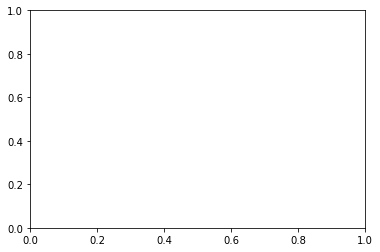

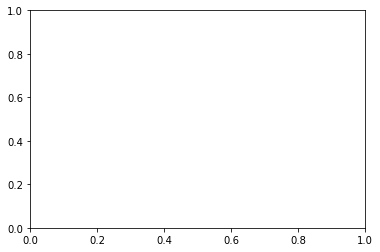

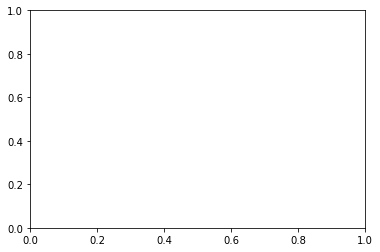

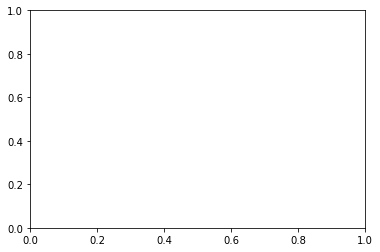

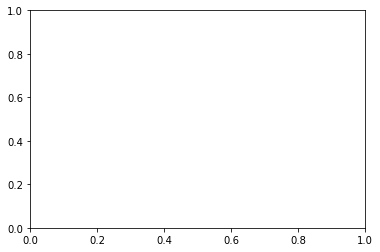

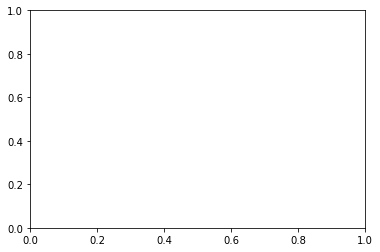

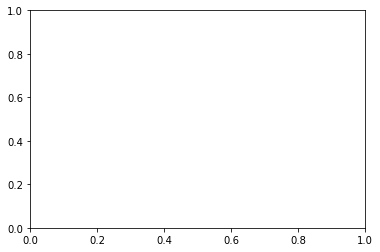

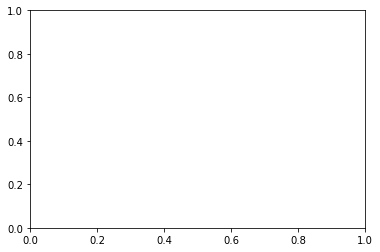

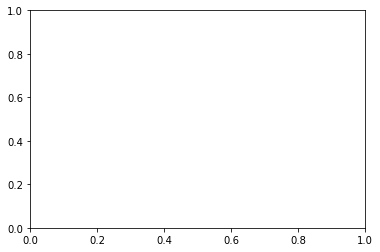

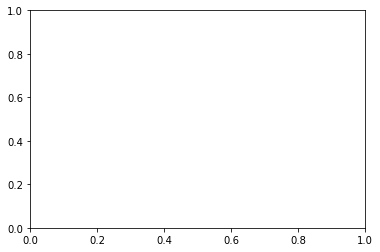

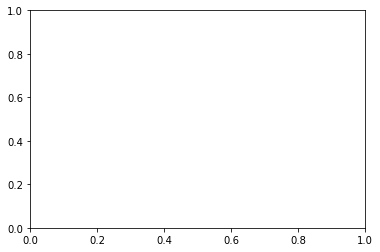

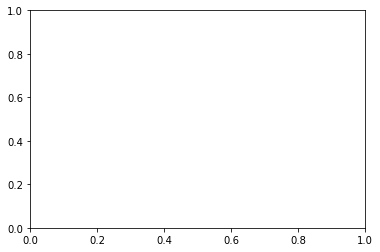

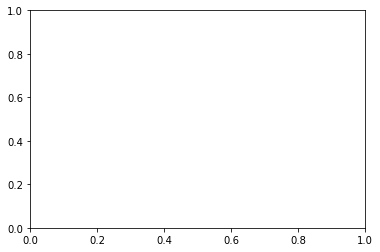

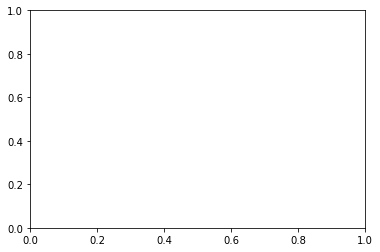

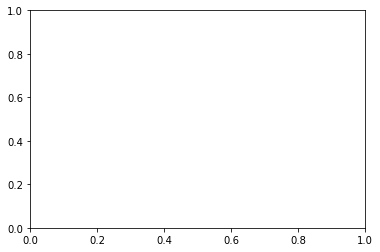

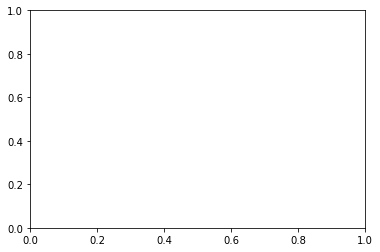

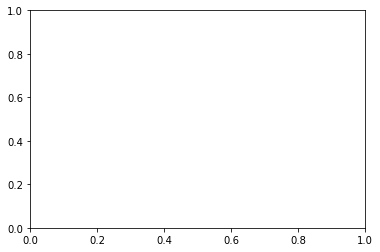

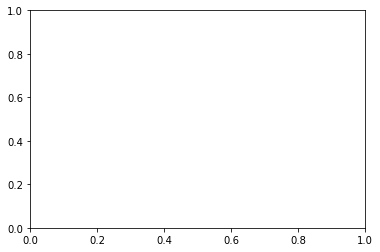

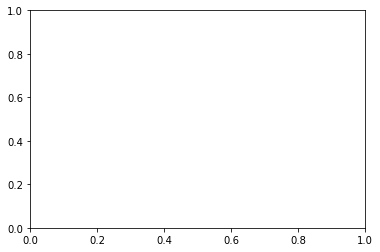

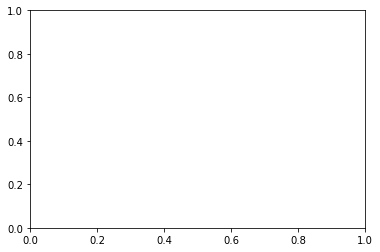

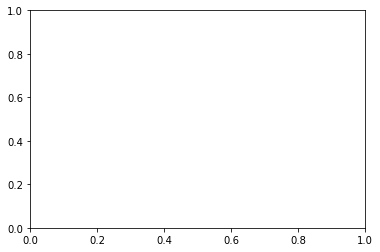

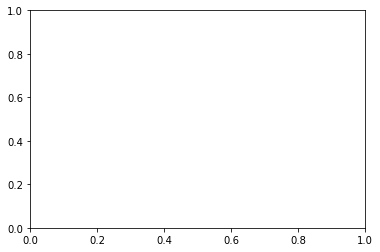

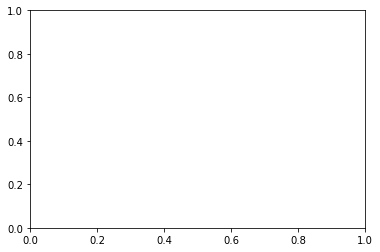

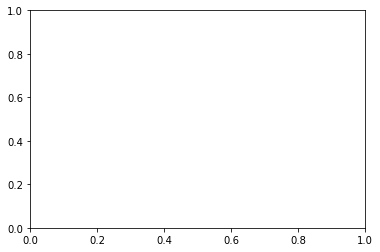

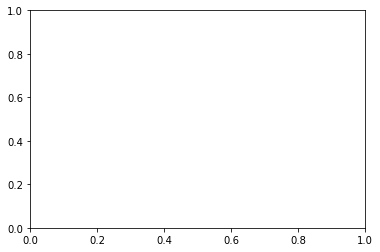

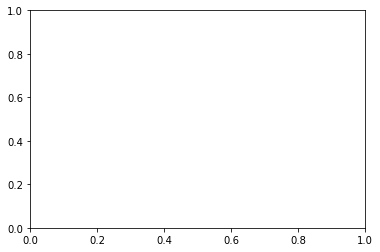

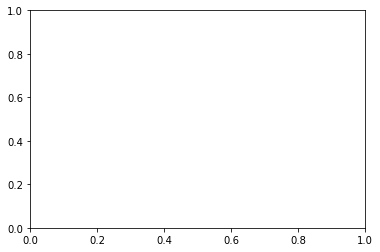

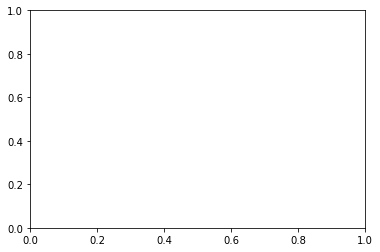

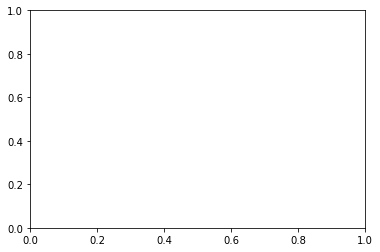

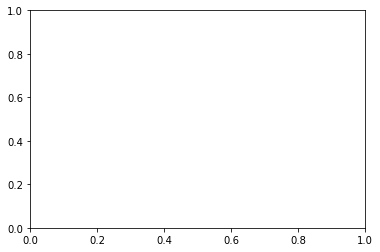

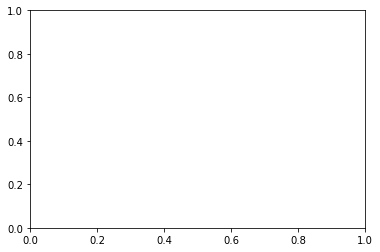

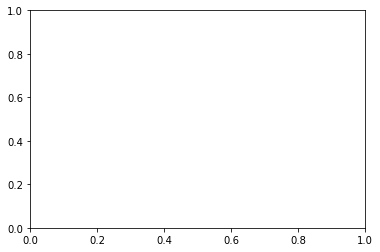

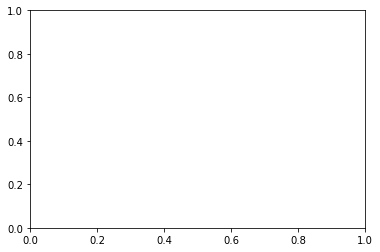

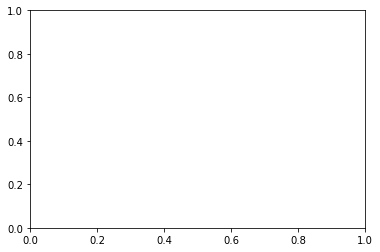

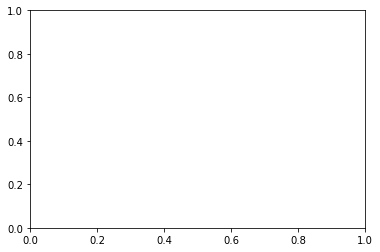

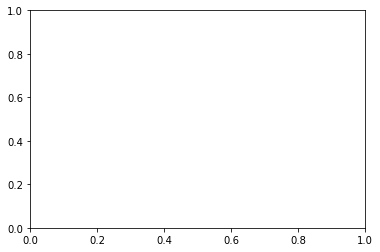

In [17]:
excludelist=[3]
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio']

allcolors=sns.color_palette("tab20",len(plotclusters))
valgradthresh=4

def plotLoss_gradPlots(ctnp,name,plotsavepath,savenameAdd=''):
    if not os.path.exists(plotsavepath):
        os.mkdir(plotsavepath)
#     for x in range(len(colnames)-1):
    for x in range(1):
        if x in excludelist:
            continue
#         for y in range(len(colnames)-1,len(colnames)):
        for y in range(14,15):
            if y in excludelist:
                continue
            fig, ax = plt.subplots()
            res0=np.array([])
            res1=np.array([])
            for ct in range(len(plotclusters)):
                cidx=gaeclusterlabels[sampleNames==s]==plotclusters[ct]
                cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
                allCTnp=celltype_broad[sampleNames==s][cidx]
                curridx=allCTnp==c

                if np.sum(curridx)==0:
                    continue
                if x==0:
                    plotx=np.log(res[s][plotclusters[ct]][curridx,x]+0.5)
                    plotidx=plotx>valgradthresh
                    plotx=plotx[plotidx]
                    ploty=res[s][plotclusters[ct]][curridx,y][plotidx]
#                     ax.scatter(plotx,ploty,color=allcolors[ct],s=1,label=clusterplotname[plotclusters[ct]])
                    res0=np.concatenate((res0,plotx))
                    res1=np.concatenate((res1,ploty))
                else:
                    ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])
            
            regrs=linregress(res0,res1)
            print(regrs.pvalue)
            print(regrs.slope)
#             axes = plt.gca()
#             x_vals = np.array(axes.get_xlim())
#             y_vals = regrs.intercept + regrs.slope * x_vals
#             plt.plot(x_vals, y_vals, '--',color='r')
            
#             ax.legend()
#             ax.set_xlabel(colnamesloggrad[x])
#             if x==0:
#                 ax.set_xlim(valgradthresh,np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
# #                 ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#             else:
#                 ax.set_xlim(minvalues[c][x],maxvalues[c][x])
#             ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
#             ax.set_ylabel(colnames[y])
#             ax.grid(False)
#             plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_gradthresh.jpg'),dpi=400)
#             plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in np.unique(celltype_broad):
        
        cidx=celltype_broad[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)<10:
            continue
        print(c)
        if np.sum(cidx)>0:
            allCTnp=gaeclusterlabels[sampleNames==s][cidx]
            plotLoss_gradPlots(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


In [180]:
#scatter by cell type
excludelist=[3]
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']

def plotLoss_gradPlots(ctnp,ctsubnp,name,plotsavepath,savenameAdd=''):
    
#     for x in range(len(colnames)-1):
    for x in range(6,7):
        if x in excludelist:
            continue
#         for y in range(len(colnames)-1,len(colnames)):
        for y in range(7,8):
            if y in excludelist:
                continue
            
            for ct in range(np.unique(celltype_broad).size):
                currBroad=np.unique(celltype_broad)[ct]
                curridx=ctnp==np.unique(celltype_broad)[ct]
                if np.sum(curridx)==0:
                    continue
                currsublist=np.unique(ctsubnp[curridx])
                allcolors=sns.color_palette("tab10",currsublist.size)
                fig, ax = plt.subplots()
                for ctsubidx in range(currsublist.size):
                    ctsubi=currsublist[ctsubidx]
                    curridx_sub=np.logical_and(curridx,(ctsubnp==ctsubi).flatten())
                    if x==0:
                        ax.scatter(np.log(res[s][c][curridx_sub,x]+0.5),res[s][c][curridx_sub,y],color=allcolors[ctsubidx],s=1,label=ctsubi)
                    else:
                        ax.scatter(res[s][c][curridx_sub,x],res[s][c][curridx_sub,y],color=allcolors[ctsubidx],s=1,label=ctsubi)

                ax.legend()
                ax.set_xlabel(colnamesloggrad[x])
#                 if x==0:
#                     ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#                 else:
#                     ax.set_xlim(minvalues[c][x],maxvalues[c][x])
#                 ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
                ax.set_ylabel(colnames[y])
                plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+currBroad+'.jpg'),dpi=400)
                plt.close()
        
for s in plot_samples.keys():
    if 'control' in s:
        continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
            plotLoss_gradPlots(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
1
3
disease8
0
1
3


In [296]:
#mean intensity vs volume, colored by avg dist to 3 nn
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
x=6
y=7
coloridx=12
def plotLoss_gradPlots(ctnp,ctsubnp,name,plotsavepath,savenameAdd=''):
    
    for ct in range(np.unique(allCTnp).size):
        currBroad=np.unique(allCTnp)[ct]
        curridx=ctnp==np.unique(allCTnp)[ct]
        if np.sum(curridx)==0:
            continue
        fig, ax = plt.subplots()
        if x==0:
            sc=ax.scatter(np.log(res[s][c][curridx,x]+0.5),res[s][c][curridx,y],c=np.log(res[s][c][curridx,coloridx]+0.5),cmap='coolwarm',s=1)
        else:
            sc=ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],c=np.log(res[s][c][curridx,coloridx]+0.5),cmap='coolwarm',s=1)

        ax.set_xlabel(colnamesloggrad[x])
#                 if x==0:
#                     ax.set_xlim(np.log(min(minvalues['0'][x],minvalues['1'][x])+0.5),np.log(max(maxvalues['0'][x],maxvalues['1'][x])+0.5))
#                 else:
#                     ax.set_xlim(minvalues[c][x],maxvalues[c][x])
#                 ax.set_ylim(min(minvalues['0'][y],minvalues['1'][y]),max(maxvalues['0'][y],maxvalues['1'][y]))
        ax.set_ylabel(colnames[y])
        fig.colorbar(sc)
        plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_logcolor'+colnames[coloridx]+currBroad+'.jpg'),dpi=400)
        plt.close()
        
for s in plot_samples.keys():
    if 'control' not in s:
        continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
#             allCTnp=np.repeat('all',allCTnp.size)
            plotLoss_gradPlots(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


control13
0
1
3
control8
0
1
3


In [295]:
#mean intensity vs volume, colored by avg dist to 3 nn -- heatmap
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
colnamesloggrad=['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
x=6
y=7
coloridx=12
ngrid=20
def plotLoss_gradPlots(ctnp,ctsubnp,name,plotsavepath,savenameAdd=''):
    
    for ct in range(np.unique(allCTnp).size):
        currBroad=np.unique(allCTnp)[ct]
        curridx=ctnp==np.unique(allCTnp)[ct]
        if np.sum(curridx)==0:
            continue
        fig, ax = plt.subplots()
        if x==0:
            xvalues=np.log(res[s][c][curridx,x]+0.5)
        else:
            xvalues=res[s][c][curridx,x]
        xvalues=xvalues
        yvalues=res[s][c][curridx,y]
        cvalues=np.log(res[s][c][curridx,coloridx]+0.5)
        heatmap=np.zeros((ngrid,ngrid))
        xstep=(np.max(xvalues)+0.01-np.min(xvalues))/ngrid
        ystep=(np.max(yvalues)+0.01-np.min(yvalues))/ngrid
        for xi in range(ngrid):
            for yi in range(ngrid):
                currminx=xi*xstep
                currmaxx=(xi+1)*xstep
                currminy=yi*ystep
                currmaxy=(yi+1)*ystep
                xrange=np.logical_and(xvalues>=currminx,xvalues<currmaxx)
                yrange=np.logical_and(yvalues>=currminy,yvalues<currmaxy)
                heatmap[xi,yi]=np.mean(cvalues[np.logical_and(xrange,yrange)])
        sc=ax.imshow(heatmap,cmap='coolwarm',origin='lower')
        ax.set_xlabel(colnamesloggrad[x])
        ax.set_ylabel(colnames[y])
        fig.colorbar(sc)
        plt.savefig(os.path.join(plotsavepath,s+colnamesloggrad[x]+'_'+colnames[y]+'_logcolor'+colnames[coloridx]+currBroad+'heatmap_highres.jpg'),dpi=400)
        plt.close()
        
for s in plot_samples.keys():
    if 'control' not in s:
        continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
#             allCTnp=np.repeat('all',allCTnp.size)
            plotLoss_gradPlots(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


control13
0


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
3
control8
0
1
3


In [308]:
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.2,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'avg dist to 3 NN':100,'HC intensity ratio':0.8} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50} #label 2; cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
#label0 is no label in subtype (hc 0.8) no label is label 2 in subtype (hc 0.5)
# piechartcutoffskeys=['log avg grad','mean intensity','area','avg dist to 20 NN','HC ratio','avg dist to 3 NN']
piechartcutoffskeys=['log avg grad','HC intensity ratio']

xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
def plotLoss_gradPlots_pie(ctnp,name,plotsavepath,savenameAdd=''):
    resplot=np.copy(res[s][c])
    resplot[:,0]=np.log(resplot[:,0]+0.5)
    for x in range(len(piechartcutoffskeys)-1):
        xname=piechartcutoffskeys[x]
        print(xname)
        for y in range(x+1,len(piechartcutoffskeys)):
            if 'control' in s and piechartcutoffskeys[y]=='log plaque':
                continue
            yname=piechartcutoffskeys[y]
            print(yname)
            fig, ax = plt.subplots()
#             r0=0
            legends=[]
            existingct=[]
            for xpos_i in xpos:
                print(xname+str(np.where(colnamesloggrad==xname)))
                if xpos_i==0:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                else:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                for ypos_i in ypos:
                    if ypos_i==0:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                    else:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                    print('xpos')
                    print(np.where(colnamesloggrad==xname))
                    cidx=np.logical_and(xposIdx,yposIdx)
                    ctnp_i=ctnp[cidx]
                    r0=0
                    for ct in range(np.unique(celltype_broad).size):
                        curridx=ctnp_i==np.unique(celltype_broad)[ct]
                        if np.sum(curridx)==0:
                            continue
        #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                        # first define the ratios
                        r1 = r0+np.sum(curridx)/curridx.size
                        print(r0)
                        print(r1)

                        # define some sizes of the scatter marker
                        sizes = 42000

                        # calculate the points of the first pie marker
                        # these are just the origin (0, 0) + some (cos, sin) points on a circle
                        x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                        y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
#                         print(x1*x1+y1*y1)
                        xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
#                         xy1=np.row_stack((xy1,[0,0]))
                        s1 = np.sum(cidx)/cidx.size
#                         print(s1**2 * sizes)

                        ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                        legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                        existingct.append(np.unique(celltype_broad)[ct])
                        r0=r1
            existingct_unique,ectidx=np.unique(existingct,return_index=True)
            ax.legend(np.array(legends)[ectidx],existingct_unique)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            ax.set_xlim(-1,2)
            ax.set_ylim(-1,2)
            plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_radii_label0.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_gradPlots_pie(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad
HC intensity ratio
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.05807365439093484
0.05807365439093484
0.07648725212464588
0.07648725212464588
0.821529745042493
0.821529745042493
0.9178470254957508
0.9178470254957508
0.9475920679886687
0.9475920679886687
0.9603399433427763
0.9603399433427763
0.9858356940509916
0.9858356940509916
1.0
xpos
(array([0]),)
0
0.15151515151515152
0.15151515151515152
0.4242424242424242
0.4242424242424242
0.5454545454545454
0.5454545454545454
0.6666666666666666
0.6666666666666666
0.8787878787878788
0.8787878787878788
0.9696969696969697
0.9696969696969697
1.0
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.0718232044198895
0.0718232044198895
0.10773480662983426
0.10773480662983426
0.5966850828729282
0.5966850828729282
0.7375690607734807
0.7375690607734807
0.839779005524862
0.839779005524862
0.861878453038674
0.861878453038674
0.9806629834254144
0.9806629834254144
1.0
xpos
(array([0]),)
0
0.024
0.024
0.376
0.376
0.4
0.4
0.416000000000

1
log avg grad
HC intensity ratio
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.053125
0.053125
0.059375
0.059375
0.7531249999999999
0.7531249999999999
0.871875
0.871875
0.9093749999999999
0.9093749999999999
0.9218749999999999
0.9218749999999999
0.9906249999999999
0.9906249999999999
0.9999999999999999
xpos
(array([0]),)
0
0.1111111111111111
0.1111111111111111
0.3
0.3
0.6888888888888889
0.6888888888888889
0.7111111111111111
0.7111111111111111
0.8222222222222222
0.8222222222222222
0.8444444444444444
0.8444444444444444
0.9666666666666667
0.9666666666666667
1.0
log avg grad(array([0]),)
xpos
(array([0]),)
0
0.057971014492753624
0.057971014492753624
0.07660455486542443
0.07660455486542443
0.743271221532091
0.743271221532091
0.8612836438923395
0.8612836438923395
0.9047619047619047
0.9047619047619047
0.9233954451345755
0.9233954451345755
0.9979296066252588
0.9979296066252588
1.0
xpos
(array([0]),)
0
0.10740203193033382
0.10740203193033382
0.2002902757619739
0.2002902757619739
0.60377358490

In [23]:
res[s][c]

array([[ 6.78080857e+02,  3.34095435e+03, -1.14065960e+02, ...,
         1.04676034e+02,  1.10547547e-01,  4.28151735e-01],
       [ 6.78747958e+02,  0.00000000e+00, -1.11763365e+02, ...,
         1.01431256e+02,  1.25859850e-01,  5.25417348e-01],
       [ 7.49994938e+02,  1.12457969e+04, -1.21379904e+02, ...,
         1.01460651e+02,  1.13577104e-01,  4.89045214e-01],
       ...,
       [ 9.84347648e+02,  1.92087148e+04, -5.18147831e+01, ...,
         1.45019033e+02,  1.02486793e-01,  4.83760949e-01],
       [ 5.70413430e+02,  2.54437441e+04, -7.17950305e+01, ...,
         1.61708377e+02,  1.18586443e-01,  5.36413726e-01],
       [ 3.36213404e+02,  1.85036719e+04, -3.03243540e+01, ...,
         1.09302598e+02,  1.25153843e-01,  5.59662725e-01]])

In [27]:
matplotlib.rcdefaults()

In [28]:
## combine all CT for pie charts
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.2,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.8} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','HC intensity ratio']
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
def plotLoss_gradPlots_pie(ctnp,name,plotsavepath,savenameAdd=''):
    resplot=np.copy(res[s][c])
    resplot[:,0]=np.log(resplot[:,0]+0.5)
    for x in range(len(piechartcutoffskeys)-1):
        xname=piechartcutoffskeys[x]
        for y in range(x+1,len(piechartcutoffskeys)):
            yname=piechartcutoffskeys[y]
            fig, ax = plt.subplots()
#             r0=0
            legends=[]
            existingct=[]
            for xpos_i in xpos:
                print(xname+str(np.where(colnamesloggrad==xname)))
                if xpos_i==0:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                else:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                for ypos_i in ypos:
                    print(yname+str(np.where(colnamesloggrad==yname)))
                    if ypos_i==0:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                    else:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                    cidx=np.logical_and(xposIdx,yposIdx)
                    ctnp_i=ctnp[cidx]
                    r0=0
                    r1=0.9999
                    sizes = 42000

                    # calculate the points of the first pie marker
                    # these are just the origin (0, 0) + some (cos, sin) points on a circle
                    x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                    y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
#                         print(x1*x1+y1*y1)
                    xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
#                         xy1=np.row_stack((xy1,[0,0]))
                    s1 = np.sum(cidx)/cidx.size
#                         print(s1**2 * sizes)

                    ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor='red',linewidths=0)
                    
            existingct_unique,ectidx=np.unique(existingct,return_index=True)
            ax.legend(np.array(legends)[ectidx],existingct_unique)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            ax.set_xlim(-1,2)
            ax.set_ylim(-1,2)
            plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_noCT.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#     if 'disease' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_gradPlots_pie(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
1
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
2
3
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
4
5
6
7
8
control13
0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
1
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
2
3
log avg grad(array([0]),)
HC inten

In [60]:
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50} #label 2; cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','dapi','log plaque']
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM'])

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
def plotLoss_gradPlots_pie(ctnp,name,plotsavepath,savenameAdd=''):
    resplot=np.copy(res[s][c])
    resplot[:,0]=np.log(resplot[:,0]+0.5)
    for x in range(len(piechartcutoffskeys)-1):
        xname=piechartcutoffskeys[x]
        for y in range(x+1,len(piechartcutoffskeys)):
            yname=piechartcutoffskeys[y]
            fig, ax = plt.subplots()
#             r0=0
            legends=[]
            existingct=[]
            for xpos_i in xpos:
#                 print(xname+str(np.where(colnamesloggrad==xname)))
                if xpos_i==0:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                else:
                    xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                for ypos_i in ypos:
#                     print(yname+str(np.where(colnamesloggrad==yname)))
                    if ypos_i==0:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                    else:
                        yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                    cidx=np.logical_and(xposIdx,yposIdx)
                    ctnp_i=ctnp[cidx]
                    r0=0
                    lnames=['TP','TN','FP','FN']
                    for ct in range(4):
                        curridx=ctnp_i==lnames[ct]
                        if np.sum(curridx)==0:
                            continue
        #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                        # first define the ratios
                        r1 = r0+np.sum(curridx)/curridx.size
#                         print(r0)
#                         print(r1)

                        # define some sizes of the scatter marker
                        sizes = 42000

                        # calculate the points of the first pie marker
                        # these are just the origin (0, 0) + some (cos, sin) points on a circle
                        x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                        y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
#                         print(x1*x1+y1*y1)
                        xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
#                         xy1=np.row_stack((xy1,[0,0]))
                        s1 = np.sum(cidx)/cidx.size
#                         print(s1**2 * sizes)

                        ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                        legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                        existingct.append(lnames[ct])
                        r0=r1
            existingct_unique,ectidx=np.unique(existingct,return_index=True)
            ax.legend(np.array(legends)[ectidx],existingct_unique)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            ax.set_xlim(-1,2)
            ax.set_ylim(-1,2)
            plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_TF2.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        if np.sum(cidx)>0:
            allCTnp=np.repeat('na',np.sum(cidx))
            posidx=res[s][c][:,5]>0
            negidx=res[s][c][:,5]==0
#             loss_test_all_binary=np.zeros(np.sum(cidx))
#             labels=res[s][c][:,5]
#             pred=res[s][c][:,1]
#             for i in range(np.sum(cidx)):
#                 if labels[i]>0 and pred[i]>lossThreshSize:
#                     loss_test_all_binary[i]=0
#         #         elif pred[0]+labels[0]>0.001: #original
#                 elif pred[i]>lossThreshSize or labels[i]>0:
#                     loss_test_all_binary[i]=1
#                 else:
#                     loss_test_all_binary[i]=0
            predposidx=res[s][c][:,1]>=lossThreshSize
            prednegidx=res[s][c][:,1]<lossThreshSize
            allCTnp[np.logical_and(posidx,predposidx)]='TP'
            allCTnp[np.logical_and(posidx,prednegidx)]='FN'
            allCTnp[np.logical_and(negidx,predposidx)]='FP'
            allCTnp[np.logical_and(negidx,prednegidx)]='TN'
            print(np.sum(negidx))
            print(np.sum(posidx))
#             print(np.sum(loss_test_all_binary[negidx])/np.sum(negidx))
#             print(np.sum(loss_test_all_binary[posidx])/np.sum(posidx))
            plotLoss_gradPlots_pie(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
837
446
1
408
839
2
1437
420
3
692
485
4
1002
473
5
831
468
6
913
61
7
684
25
8
control13
0
1418
0
1
1190
0
2
1534
0
3
880
0
4
996
0
5
548
0
6
558
0
7
627
0
8
15
0
disease8
0
1093
255
1
957
714
2
429
11
3
800
337
4
605
96
5
529
85
6
667
0
7
679
0
8
control8
0
1644
0
1
694
0
2
844
0
3
1415
0
4
1073
0
5
762
0
6
988
0
7
642
0
8


In [65]:
#pie charts by subtypes
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.8} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.2,'dapi':0.2,'log plaque':-50,'mean intensity':0.4, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.5,'HC intensity ratio':0.5} #label 2; cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.5} #label 3 cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.85} #label 4 cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50,'mean intensity':0.27, 'area':0.3e6,'avg dist to 20 NN':350,'HC ratio':0.8,'HC intensity ratio':0.9} #label 5 cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','HC intensity ratio']
# xpos=[1,0]
# ypos=[1,0]
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])



def plotLoss_gradPlots_pie_byct(ctnp_all,ctnp_sub_all,name,plotsavepath,savenameAdd=''):
    resplot_all=np.copy(res[s][c])
    resplot_all[:,0]=np.log(resplot_all[:,0]+0.5)
    for ctbroad in range(np.unique(celltype_broad).size):
        currBroad=np.unique(celltype_broad)[ctbroad]
#         if currBroad != 'SMC':
#             continue
        ctbroadIdx=ctnp_all==currBroad
        resplot=resplot_all[ctbroadIdx]
        ctnp=ctnp_sub_all[ctbroadIdx]
#         ctnp=np.repeat('SMC',np.sum(ctbroadIdx))
        allcolors=sns.color_palette("tab10",np.unique(ctnp).size)
        for x in range(1):
#         for x in range(len(piechartcutoffskeys)-1):
            xname=piechartcutoffskeys[x]
#             for y in range(1,2):
            for y in range(x+1,len(piechartcutoffskeys)):
                yname=piechartcutoffskeys[y]
                fig, ax = plt.subplots()
    #             r0=0
                legends=[]
                existingct=[]
                for xpos_i in xpos:
                    print(xname+str(np.where(colnamesloggrad==xname)))
                    if xpos_i==0:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                    else:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                    for ypos_i in ypos:
                        print(yname+str(np.where(colnamesloggrad==yname)))
                        if ypos_i==0:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                        else:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                        cidx=np.logical_and(xposIdx,yposIdx)
                        ctnp_i=ctnp[cidx]
                        r0=0
                        for ct in range(np.unique(ctnp).size):
                            curridx=ctnp_i==np.unique(ctnp)[ct]
#                             if np.unique(ctnp)[ct] != 'Oligo':
#                                 continue
                            if np.sum(curridx)==0:
                                continue
            #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                            # first define the ratios
                            r1 = r0+np.sum(curridx)/curridx.size
                            print(r0)
                            print(r1)

                            # define some sizes of the scatter marker
                            sizes = 42000

                            # calculate the points of the first pie marker
                            # these are just the origin (0, 0) + some (cos, sin) points on a circle
                            x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                            y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
    #                         print(x1*x1+y1*y1)
                            xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    #                         xy1=np.row_stack((xy1,[0,0]))
                            s1 = np.sum(cidx)/cidx.size
    #                         print(s1**2 * sizes)

                            ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                            legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                            existingct.append(np.unique(ctnp)[ct])
                            r0=r1
                existingct_unique,ectidx=np.unique(existingct,return_index=True)
                ax.legend(np.array(legends)[ectidx],existingct_unique)
                ax.set_xlabel(xname)
                ax.set_ylabel(yname)
                ax.set_xlim(-1,2)
                ax.set_ylim(-1,2)
                plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_'+currBroad+'label5.jpg'),dpi=400)
                plt.close()
        
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            allCTsubnp=celltype_sub[sampleNames==s][cidx]
            plotLoss_gradPlots_pie_byct(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.5362318840579711
0.5362318840579711
0.9420289855072465
0.9420289855072465
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.5
0.5
0.8333333333333333
0.8333333333333333
0.9999999999999999
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg gra

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.7058823529411765
0.7058823529411765
0.8823529411764707
0.8823529411764707
1.0
HC intensity ratio(array([14]),)
0
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.529411764

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.12244897959183673
0.12244897959183673
0.14285714285714285
0.14285714285714285
0.7857142857142858
0.7857142857142858
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.6153846153846154
0.6153846153846154
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.8571428571428571
0.8571428571428571
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC inten

1
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.6506024096385542
0.6506024096385542
0.9156626506024097
0.9156626506024097
1.0
HC intensity ratio(array([14]),)
0
0.4166666666666667
0.4166666666666667
0.9166666666666667
0.9166666666666667
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.5416666666666666
0.5416666666666666
0.875
0.875
1.0
HC intensity ratio(array([14]),)
0
0.4
0.4
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.6276595744680851
0.6276595744680851
0.8617021276595744
0.8617021276595744
1.0
HC intensity ratio(array([14]),)
0
0.7
0.7
0.7999999999999999
0.7999999999999999
1.0
log avg grad(a

log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.68
0.68
0.9600000000000001
0.9600000000000001
1.0
HC intensity ratio(array([14]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.65
0.65
0.8
0.8
1.0
HC intensity ratio(array([14]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.1394700139470014
0.1394700139470014
0.34309623430962344
0.34309623430962344
0.36401673640167365
0.36401673640167365
1.0
HC intensity ratio(array([14]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.10526315789473684
0.10526315789473684
0.22807017543859648
0.22807017543859648
0.2631578947368421
0.2631578947368421
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(array([14]),)
0
0.15942028985507245
0.15942028985507245
0.20289855072463767
0.20289855072463767
0.6231884057971014
0.6231884057971014
1.0
HC intensity ratio(array([14]),)
log avg grad(array([0]),)
HC intensity ratio(arr

In [34]:
#pie charts by subtypes -TF
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','dapi','log plaque']
# xpos=[1,0]
# ypos=[1,0]
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM'])


def plotLoss_gradPlots_pie_byct(ctnp_all,ctnp_sub_all,name,plotsavepath,savenameAdd=''):
    resplot_all=np.copy(res[s][c])
    resplot_all[:,0]=np.log(resplot_all[:,0]+0.5)
    lnames=np.array(['TP','TN','FP','FN'])
    for ctbroad in range(np.unique(celltype_broad).size):
        currBroad=np.unique(celltype_broad)[ctbroad]
#         if currBroad != 'SMC':
#             continue
        ctbroadIdx=ctnp_all==currBroad
        resplot=resplot_all[ctbroadIdx]
        ctnp=ctnp_sub_all[ctbroadIdx]
#         ctnp=np.repeat('SMC',np.sum(ctbroadIdx))
        allcolors=sns.color_palette("tab10",lnames.size)
        for x in range(len(piechartcutoffskeys)-1):
            xname=piechartcutoffskeys[x]
            for y in range(x+1,len(piechartcutoffskeys)):
                yname=piechartcutoffskeys[y]
                fig, ax = plt.subplots()
    #             r0=0
                legends=[]
                existingct=[]
                for xpos_i in xpos:
                    print(xname+str(np.where(colnamesloggrad==xname)))
                    if xpos_i==0:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                    else:
                        xposIdx=resplot[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                    for ypos_i in ypos:
                        print(yname+str(np.where(colnamesloggrad==yname)))
                        if ypos_i==0:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                        else:
                            yposIdx=resplot[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                        cidx=np.logical_and(xposIdx,yposIdx)
                        ctnp_i=ctnp[cidx]
                        r0=0
                        for ct in range(lnames.size):
                            curridx=ctnp_i==lnames[ct]
                            if np.sum(curridx)==0:
                                continue
            #                 ax.scatter(res[s][c][curridx,x],res[s][c][curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])

                            # first define the ratios
                            r1 = r0+np.sum(curridx)/curridx.size
                            print(r0)
                            print(r1)

                            # define some sizes of the scatter marker
                            sizes = 42000

                            # calculate the points of the first pie marker
                            # these are just the origin (0, 0) + some (cos, sin) points on a circle
                            x1 = np.cos(2 * np.pi * np.linspace(r0, r1,1000))
                            y1 = np.sin(2 * np.pi * np.linspace(r0, r1,1000))
    #                         print(x1*x1+y1*y1)
                            xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
    #                         xy1=np.row_stack((xy1,[0,0]))
                            s1 = np.sum(cidx)/cidx.size
    #                         print(s1**2 * sizes)

                            ax.scatter(xpos_i, ypos_i, marker=xy1, s=s1**2*np.abs(xy1).max()**2 * sizes, facecolor=allcolors[ct],linewidths=0)
                            legends.append(Line2D([0], [0], color=allcolors[ct], lw=4))
                            existingct.append(lnames[ct])
                            r0=r1
                existingct_unique,ectidx=np.unique(existingct,return_index=True)
                ax.legend(np.array(legends)[ectidx],existingct_unique)
                ax.set_xlabel(xname)
                ax.set_ylabel(yname)
                ax.set_xlim(-1,2)
                ax.set_ylim(-1,2)
                plt.savefig(os.path.join(plotsavepath,s+xname+'_'+yname+'piechart_'+currBroad+'_TF.jpg'),dpi=400)
                plt.close()
        
for s in plot_samples.keys():
#     if 'disease' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
#             allCTsubnp=celltype_sub[sampleNames==s][cidx]
            allCTsubnp=np.repeat('na',np.sum(cidx))
            posidx=res[s][c][:,5]>0
            negidx=res[s][c][:,5]==0
            predposidx=res[s][c][:,1]>=lossThreshSize
            prednegidx=res[s][c][:,1]<lossThreshSize
            allCTsubnp[np.logical_and(posidx,predposidx)]='TP'
            allCTsubnp[np.logical_and(posidx,prednegidx)]='FN'
            allCTsubnp[np.logical_and(negidx,predposidx)]='FP'
            allCTsubnp[np.logical_and(negidx,prednegidx)]='TN'
            plotLoss_gradPlots_pie_byct(allCTnp,allCTsubnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.21212121212121213
0.21212121212121213
0.6666666666666666
0.6666666666666666
1.0
dapi(array([3]),)
0
0.18181818181818182
0.18181818181818182
0.8181818181818181
0.8181818181818181
0.9393939393939393
0.9393939393939393
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.45454545454545453
0.45454545454545453
0.5454545454545454
0.5454545454545454
0.9090909090909091
0.9090909090909091
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.6818181818181818
0.6818181818181818
1.0
log plaque(array([2]),)
0
0.5909090909090909
0.5909090909090909
0.8636363636363636
0.8636363636363636
0.9090909090909091
0.9090909090909091
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log plaque(array([2]),)
0
0.75
0.75
0.875
0.875
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.5833333333333334
0.5833333333333334
1.0
log plaque(array([2]),)
0
0.8
0.8
0.9
0.9
1.0
dapi(array([3]),)
log plaque(array([2]),)


log avg grad(array([0]),)
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
0.5555555555555556
0.5555555555555556
0.8888888888888888
0.8888888888888888
1.0
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
0.6666666666666666
0.6666666666666666
0.8333333333333333
0.8333333333333333
0.9999999999999999
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5714285714285714
0.5714285714285714
1.0
log plaque(array([2]),)
0
0.625
0.625
0.75
0.75
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.4
0.4
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.6666666666666666
0.6666666666666666
1.0
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.36363636363636365
0.36363636363636365
0

dapi(array([3]),)
log plaque(array([2]),)
0
0.18181818181818182
0.18181818181818182
1.0
log plaque(array([2]),)
0
0.6093189964157706
0.6093189964157706
0.6810035842293907
0.6810035842293907
0.8243727598566308
0.8243727598566308
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.21739130434782608
0.21739130434782608
1.0
log plaque(array([2]),)
0
0.5748031496062992
0.5748031496062992
0.6377952755905512
0.6377952755905512
0.7480314960629921
0.7480314960629921
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5409836065573771
0.5409836065573771
0.6557377049180328
0.6557377049180328
0.9016393442622952
0.9016393442622952
1.0
dapi(array([3]),)
0
0.2
0.2
0.4
0.4
0.8
0.8
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.8
0.8
1.0
dapi(array([3]),)
0
0.6
0.6
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.35294117647058826
0.35294117647058826
1.0
log plaque(array([2]),)
0
0.6938775510204082
0.6938775510204082
0.7346938775510204
0.7346938775510204
0.8571428571428572
0.857142857142857

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.20270270270270271
0.20270270270270271
0.5
0.5
0.8716216216216216
0.8716216216216216
1.0
dapi(array([3]),)
0
0.07648183556405354
0.07648183556405354
0.5248565965583174
0.5248565965583174
0.8795411089866156
0.8795411089866156
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.1574642126789366
0.1574642126789366
0.39877300613496935
0.39877300613496935
0.9386503067484663
0.9

log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log pl

log avg grad(array([0]),)
log plaque(array([2]),)
0
0.2857142857142857
0.2857142857142857
1.0
log plaque(array([2]),)
0
0.5
0.5
0.5652173913043478
0.5652173913043478
0.9130434782608695
0.9130434782608695
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.16666666666666666
0.16666666666666666
0.986111111111111
0.986111111111111
0.9999999999999999
log plaque(array([2]),)
0
0.6067415730337079
0.6067415730337079
0.6853932584269663
0.6853932584269663
0.9662921348314607
0.9662921348314607
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.24
0.24
1.0
log plaque(array([2]),)
0
0.5333333333333333
0.5333333333333333
0.6
0.6
0.9333333333333333
0.9333333333333333
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.19718309859154928
0.19718309859154928
0.9859154929577464
0.9859154929577464
0.9999999999999999
log plaque(array([2]),)
0
0.5888888888888889
0.5888888888888889
0.6666666666666667
0.6666666666666667
0.9555555555555556
0.9555555555555556
1.0
log avg grad(array([0]),)
dapi(array([3]),)


log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5909090909090909
0.5909090909090909
0.6060606060606061
0.6060606060606061
0.9090909090909092
0.9090909090909092
1.0
dapi(array([3]),)
0
0.25925925925925924
0.25925925925925924
0.3333333333333333
0.3333333333333333
0.8888888888888888
0.8888888888888888
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.6
0.6
0.7
0.7
1.0
dapi(array([3]),)
0
0.5029585798816568
0.5029585798816568
0.5207100591715976
0.5207100591715976
0.9822485207100592
0.9822485207100592
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.08
0.08
1.0
log plaque(array([2]),)
0
0.6764705882352942
0.6764705882352942
0.6911764705882353
0.69117

0.4666666666666667
0.9666666666666667
0.9666666666666667
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.125
0.125
1.0
log plaque(array([2]),)
0
0.8333333333333334
0.8333333333333334
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.7142857142857143
0.7142857142857143
0.9523809523809523
0.9523809523809523
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.1111111111111111
0.1111111111111111
1.0
log plaque(array([2]),)
0
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.7368421052631579
0.7368421052631579
0.9473684210526315
0.9473684210526315
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(

log avg grad(array([0]),)
dapi(array([3]),)
0
0.6923076923076923
0.6923076923076923
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.7692307692307693
0.7692307692307693
1.0
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
0.7272727272727273
0.7272727272727273
1.0
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.6666666666666666
0.6666666666666666
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.8888888888888888
0.8888888888888888
1.0
dapi(array([3]),)
0
0.75
0.75
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.6
0.6
0.8
0.8
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]

log avg grad(array([0]),)
dapi(array([3]),)
0
0.00273224043715847
0.00273224043715847
0.8770491803278688
0.8770491803278688
0.9672131147540983
0.9672131147540983
1.0
dapi(array([3]),)
0
0.9029126213592233
0.9029126213592233
0.9514563106796117
0.9514563106796117
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.9153318077803204
0.9153318077803204
1.0
log plaque(array([2]),)
0
0.03125
0.03125
0.4375
0.4375
0.46875
0.46875
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.9058823529411765
0.9058823529411765
1.0
log plaque(array([2]),)
0
0.038461538461538464
0.038461538461538464
0.5
0.5
0.5384615384615384
0.5384615384615384
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.9484536082474226
0.9484536082474226
1.0
log plaque(array([2]),)
0
0.14285714285714285
0.14285714285714285
0.2857142857142857
0.2857142857142857
1.0
log avg grad(array

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.8571428571428571
0.8571428571428571
1.0
dapi(array([3]),)
0
0.9
0.9
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8764044943820225
0.8764044943820225
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8571428571428571
0.8571428571428571
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8809523809523809
0.8809523809523809
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.9135483870967742
0.9135483870967742
1.0
dapi(array([3]),)
0
0.9379310344827586
0.9379310344827586
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]

log avg grad(array([0]),)
dapi(array([3]),)
0
0.7837837837837838
0.7837837837837838
1.0
dapi(array([3]),)
0
0.8484848484848485
0.8484848484848485
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8037383177570093
0.8037383177570093
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.7837837837837838
0.7837837837837838
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.8235294117647058
0.8235294117647058
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.5555555555555556
0.5555555555555556
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.4
0.4
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6846153846153846
0.6846153846153846
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.16666666666666666
0.16666666666666666
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5211267605633803
0.5211267605633803
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5210084033613446
0.5210084033613446
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6666666666666666
0.6666666666666666
1.0
4
log avg grad(array([0]),)
dapi(array([3]),)
0
0.17105263

log avg grad(array([0]),)
dapi(array([3]),)
0
0.15384615384615385
0.15384615384615385
1.0
dapi(array([3]),)
0
0.30434782608695654
0.30434782608695654
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.0945945945945946
0.0945945945945946
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.0945945945945946
0.0945945945945946
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.15384615384615385
0.15384615384615385
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.14432989690721648
0.14432989690721648
1.0
5
log avg grad(array([0]),)
dapi(array([3]),)
0
0.2
0.2
1.0
dapi(array([3]),)
0
0.38461538461538464
0.38461538461538464
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.05
0.05
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.2727272727272727
0.272

log avg grad(array([0]),)
dapi(array([3]),)
0
0.937799043062201
0.937799043062201
1.0
dapi(array([3]),)
0
0.939622641509434
0.939622641509434
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9388185654008439
0.9388185654008439
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.937799043062201
0.937799043062201
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9363295880149812
0.9363295880149812
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.9047619047619048
0.9047619047619048
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9130434782608695
0.913

log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
disease8
0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.20833333333333334
0.20833333333333334
0.45833333333333337
0.45833333333333337
0.9583333333333334


log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5666666666666667
0.5666666666666667
1.0
log plaque(array([2]),)
0
0.25
0.25
0.40625
0.40625
0.59375
0.59375
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.42857142857142855
0.42857142857142855
1.0
log plaque(array([2]),)
0
0.5652173913043478
0.5652173913043478
0.6521739130434783
0.6521739130434783
0.8695652173913043
0.8695652173913043
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
0.41666666666666663
0.41666666666666663
0.6666666666666666
0.6666666666666666
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.5555555555555556
0.5555555555555556
1.0
log plaque(array([2]),)
0
0.3953488372093023
0.3953488372093023
0.5348837209302325
0.5348837209302325
0.7209302325581395
0.7209302325581395
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.6666666666666666
0.6666666666666666
1.0
dapi(array([3]),)
0
0.625
0.625
1.0
log avg grad(array([0]),)
dapi(array([

log avg grad(array([0]),)
log plaque(array([2]),)
0
0.47593582887700536
0.47593582887700536
1.0
log plaque(array([2]),)
0
0.2891246684350133
0.2891246684350133
0.49867374005305043
0.49867374005305043
0.7029177718832892
0.7029177718832892
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.24615384615384617
0.24615384615384617
1.0
log plaque(array([2]),)
0
0.4880382775119617
0.4880382775119617
0.5933014354066986
0.5933014354066986
0.7894736842105263
0.7894736842105263
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.40625
0.40625
1.0
log plaque(array([2]),)
0
0.34185303514376997
0.34185303514376997
0.5175718849840256
0.5175718849840256
0.744408945686901
0.744408945686901
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.35668789808917195
0.35668789808917195
1.0
log plaque(array([2]),)
0
0.38095238095238093
0.38095238095238093
0.5494505494505495
0.5494505494505495
0.7216117216117217
0.7216117216117217
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14102564102564102
0.14102564

log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.4
0.4
1.0
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
lo

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.3
0.3
0.8
0.8
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.6
0.6
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.6
0.6
1.0
4
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14285714285714285
0.14285714285714285
0.5357142857142857
0.5357142857142857
1.0
dapi(array([3]),)
0
0.11864406779661017
0.11864406779661017
0.559322033898305
0.559322033898305
0.9491525423728813
0.9491525423728813
0.9999999999999999
log avg grad(array([0]),)
dapi(array([3]),)
0
0.2
0.2
1.0
dapi(array([3]),)
0
0.13513513513513514
0.13513513513513514
0.17117117117117117
0.17117117117117117
0.990990990990991
0.990990990990991
1.0
log avg grad(array([0

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.6
0.6
0.8
0.8
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.058823529411764705
0.058823529411764705
0.11764705882352941
0.11764705882352941
0.9411764705882353
0.9411764705882353
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5555555555555556
0.5555555555555556
1.0
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.07692307692307693
0.07692307692307693
1.0
log plaque(array([2]),)
0
0.25
0.25
0.75
0.75
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
0.3
0.3
1.0
log plaque(array([2]),)
0
0.14285714285714285
0.14285714285714285
0.2857142857142857
0.2857142857142857
0.5714285714285714
0.5714285714285714
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.125
0.125
0.5
0.5
1.0
dapi(array([3]),)
0
0.07692307692307693
0.07692307692307693
0.69230769

log avg grad(array([0]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
0.42857142857142855
0.42857142857142855
0.5714285714285714
0.5714285714285714
0.8571428571428571
0.8571428571428571
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
0
0.1111111111111111
0.1111111111111111
1.0
log plaque(array([2]),)
0
0.5
0.5
0.6666666666666666
0.6666666666666666
0.8333333333333333
0.8333333333333333
0.9999999999999999
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14754098360655737
0.14754098360655737
0.22950819672131145
0.22950819672131145
1.0
dapi(array([3]),)
0
0.4
0.4
0.9500000000000001
0.9500000000000001
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.09090909090909091
0.09090909090909091
0.22727272727272727
0.22727272727272727
1.0
dapi(array([3]),)
0
0.12349397590361445
0.12349397590361445
0.1897590361445783
0.1897

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.3333333333333333
0.3333333333333333
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.25
0.25
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
1.0
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
0
0.3333333333333333
0.3333333333333333
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)


dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.4807692307692308
0.4807692307692308
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.4225352112676056
0.4225352112676056
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
da

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaq

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14285714285714285
0.14285714285714285
1.0
dapi(array([3]),)
0
0.222222222222

dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5555555555555556
0.5555555555555556
1.0
dapi(array([3]),)
0
0.6363636363636364
0.6363636363636364
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.13333333333333333
0.13333333333333333
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6
0.6
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.125
0.125
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.34615384615384615
0.34615384615384615
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.16666666666666666
0.16666666666666666
1.0
dapi(array([3]),)
0
0.5714285714285714
0.5714285714285714
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
0
1.0
log avg grad

log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.3142857142857143
0.3142857142857143
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.06172839506172839
0.06172839506172839
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.10526315789473684
0.10526315789473684
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.14432989690721648
0.14432989690721648
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.14285714285714285
0.14285714285714285
1.0
dapi(array([3]),)
0
0.5882352941176471
0.5882352941176471
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
0.12
0.12
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.3870967741935484
0.3870967741935484
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.1111111111111111
0.1111111111111111
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)


log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
6
log avg grad(array([0]),)
dapi(array([3]),)
0
0.5
0.5
1.0
dapi(array([3]),)
0
0.6363636363636364
0.6363636363636364
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6071428571428571
0.6071428571428571
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.5
0.5
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.6363636363636364
0.636363636

log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
0.9114391143911439
0.9114391143911439
1.0
dapi(array([3]),)
0
0.9318181818181818
0.9318181818181818
1.0
log avg grad(array([0]),)
dapi(array([3]),)
0
1.0
dapi(array([3]),)
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9181141439205955
0.9181141439205955
1.0
log avg grad(array([0]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
1.0
dapi(array([3]),)
log plaque(array([2]),)
log plaque(array([2]),)
0
0.9117647058823529
0.9117647058823529
1.0
dapi(array([3]),)
log plaque(array([2]),

In [25]:
#feature for DE
featureslist_full={}
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')

feature_names_full=scaleddata.var.index
feature_names_full=feature_names_full.astype(str)

scalefactor_full={}
libsizeSum_full=0
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum_full+=scalefactorS
    scalefactor_full[s]=scalefactorS
sizeFactor_full=libsizeSum_full/len(list(plot_samples.keys()))
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]
    
    scaleddata_train=np.log2(scaleddata_train*(sizeFactor_full/scalefactor_full[s])+1)
    featureslist_full[s]=scaleddata_train
    

In [93]:
np.min(featureslist_full['control13'])

0.0

In [97]:
np.max(featureslist_full['control13'])

6.508977

In [27]:
fc=1.1
pvalthresh=0.05
def de_singlesample(sample,labels,savepath,feature_names,plotOnly,ntopgene=25,vmin=0,vmax=6.51,dot_max=1):
    if np.unique(labels).shape[0]==1:
        return
    var = pd.DataFrame(data=feature_names,index=feature_names,columns=['feature_names'])
    obs = pd.DataFrame()
    obs['clusterLabel']=labels
    adata = ad.AnnData(sample, obs=obs.astype('category'),var=var.astype('category'))
    if not plotOnly:
        scanpy.tl.rank_genes_groups(adata, 'clusterLabel',use_raw=False, method='wilcoxon',pts=True)
        with open(os.path.join(savepath), 'wb') as output:
            pickle.dump(adata.uns['rank_genes_groups'], output, pickle.HIGHEST_PROTOCOL)
    else:
        with open(os.path.join(savepath), 'rb') as input:
            adata.uns['rank_genes_groups']=pickle.load(input)
#     scanpy.tl.filter_rank_genes_groups(adata,groupby='clusterLabel',use_raw=False, min_fold_change=fc,min_in_group_fraction=minIngroup,max_out_group_fraction=maxOutgroup)
    genelist=np.array([])
#     print(adata.obs['clusterLabel'])
    for l in np.unique(labels).astype(str):
#         print(l)
#         if l==-1:
#             continue
#         if np.sum(labels.astype(str)==l)<minCell_DE or np.sum(labels.astype(str)!=l)<minCell_DE:
#             continue
        resl=scanpy.get.rank_genes_groups_df(adata, group=l,pval_cutoff=pvalthresh,gene_symbols='feature_names')
#         print(resl)
#         resl=resl[np.logical_or(resl['logfoldchanges']>np.log2(fc),resl['logfoldchanges']< -np.log2(fc))]
        resl=resl[resl['logfoldchanges']>np.log2(fc)]
        np.savetxt(savepath+'UP_'+str(l)+'_fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.csv',np.array(resl['names']).reshape((-1,1)),fmt='%s')
#         resl=resl[resl['pts']>minIngroup]
        resl=resl.sort_values('pvals_adj',axis=0)
        resl=resl.iloc[:np.min([resl.shape[0],ntopgene]),:]
        genelist=np.concatenate((genelist,resl['names']))
    if genelist.shape[0]>0:
        plt.rcParams["figure.figsize"] = (12,12)
        scanpy.set_figure_params(scanpy=True, fontsize=9)
        scanpy.pl.dotplot(adata,np.unique(genelist),groupby='clusterLabel',use_raw=False,return_fig =True,vmin=vmin,vmax=vmax,dot_max=dot_max).savefig(savepath+'UP_fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'vmax'+str(vmax)+'.jpg',dpi=300)
    
    genelist=np.array([])
#     print(adata.obs['clusterLabel'])
    for l in np.unique(labels).astype(str):
#         print(l)
#         if l==-1:
#             continue
#         if np.sum(labels.astype(str)==l)<minCell_DE or np.sum(labels.astype(str)!=l)<minCell_DE:
#             continue
        resl=scanpy.get.rank_genes_groups_df(adata, group=l,pval_cutoff=pvalthresh,gene_symbols='feature_names')
#         print(resl)
#         resl=resl[np.logical_or(resl['logfoldchanges']>np.log2(fc),resl['logfoldchanges']< -np.log2(fc))]
        resl=resl[resl['logfoldchanges']<-np.log2(fc)]
        np.savetxt(savepath+'DOWN_'+str(l)+'_fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.csv',np.array(resl['names']).reshape((-1,1)),fmt='%s')
#         resl=resl[resl['pts']>minIngroup]
        resl=resl.sort_values('pvals_adj',axis=0)
        resl=resl.iloc[:np.min([resl.shape[0],ntopgene]),:]
        genelist=np.concatenate((genelist,resl['names']))
    if genelist.shape[0]>0:
        scanpy.pl.dotplot(adata,np.unique(genelist),groupby='clusterLabel',use_raw=False,return_fig =True).savefig(savepath+'DOWN_fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.jpg')

13
0
75
0
130
CA1
0
0
0
130
CA2
0
0
0
130
CA3
0
2
0
130
DG
0
1
79


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


710


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


125


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
130
LHb
0
0
93
18
130
OPC
3
3
88


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


38
130
SMC
21
6
1
102
0
131
CA1
0
0
0
131
CA2
0
0
0
131
CA3
0
0
10
131
DG
1
7
98
443


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


73
0
131
LHb
0
10
155
131
Micro
112
9
22
131
OPC
14
8
227


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


37
131
SMC
28
8
3
74
133
Astro
39
7
0
133
CA1
0
0
0
133
CA2
0
0
1
133
CA3
0
1
1
133
DG
0
2
39
133
Endo
29
6
611


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


40
133
Inhi
8
32
0
133
LHb
0
0
87
133
Micro
64
6
15
133
OPC
7
4
255


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


18
133
SMC
13
1
8
0
66
2
80
CA1
1
0
0
80
CA2
0
1


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2
80
CA3
0
0
2
80
DG
0
2
55
80
Endo
30
3
881


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


132
0
80
LHb
0
0
90
80
Micro
52
3
15
80
OPC
5
7
51
80
Oligo
27
9
15
80
SMC
14
1
1
129
81
Astro
85
4
0
81
CA1
0
0
0
81
CA2
0
0
0
81
CA3
0
1
0
81
DG
0
0
92
81
Endo
64
0
857


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: Implic

123
0
81
LHb
0
0
113
81
Micro
85
1
31
81
OPC
18
0
192
81
Oligo
129
9
45
81
SMC
34
1
3
58
83
Astro
30
3
1
83
CA1
0
0
0
83
CA2
0
0
1
83
CA3
0
1
1
83
DG
0
2
51
83
Endo
39
1
631


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


64
0
83
LHb
0
0
63
83
Micro
45
2
14
83
OPC
9
1
198


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


14
83
SMC
12
0


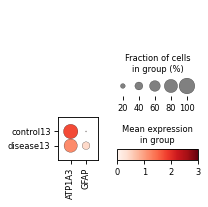

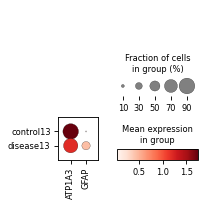

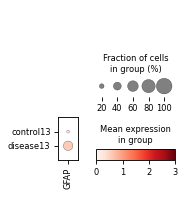

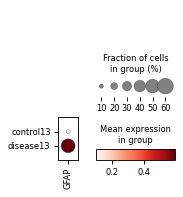

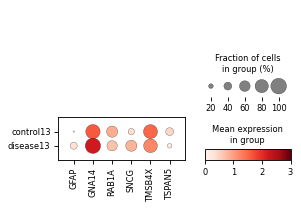

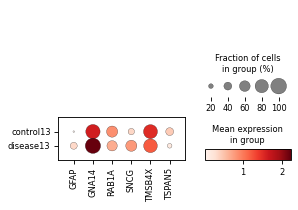

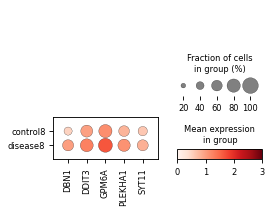

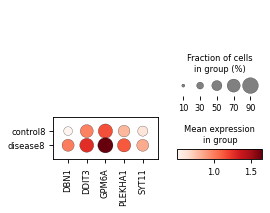

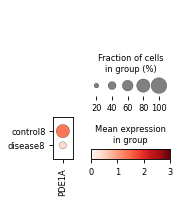

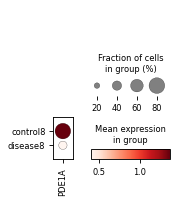

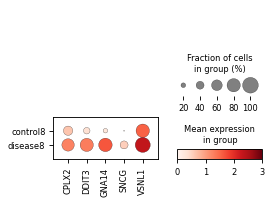

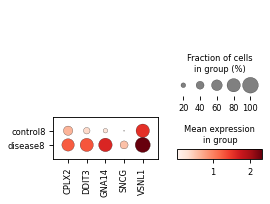

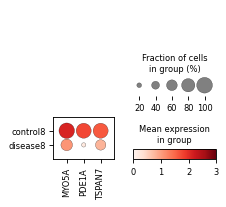

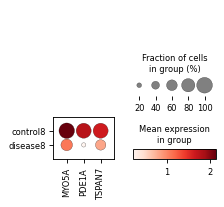

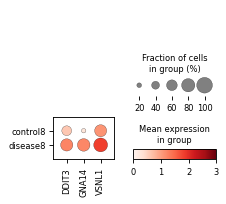

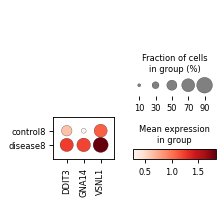

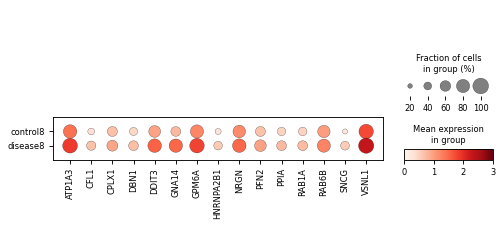

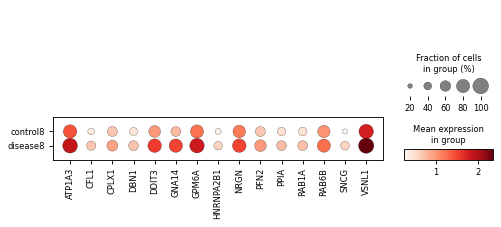

In [29]:
#pie charts by subtypes -- DE
fc=1.1
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.8}#cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.5} #label3
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.85} #label4

piechartcutoffskeys=['log avg grad','HC intensity ratio']
# xpos=[1,0]
# ypos=[1,0]
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])

DEpairs={'13':['control13','disease13'],'8':['control8','disease8']}
minCellsDE=10
# fc=1.5

def plotLoss_gradPlots_pie_byct(feature_disease,feature_control,ctnp_all_disease,ctnp_sub_all_disease,ctnp_all_control,ctnp_sub_all_control,name,plotsavepath,savenameAdd=''):
    resplot_all_disease=np.copy(res['disease'+s][c])
    resplot_all_control=np.copy(res['control'+s][c])
    resplot_all_disease[:,0]=np.log(resplot_all_disease[:,0]+0.5)
    resplot_all_control[:,0]=np.log(resplot_all_control[:,0]+0.5)
    
    for ctbroad in range(np.unique(celltype_broad).size):
        currBroad=np.unique(celltype_broad)[ctbroad]
#         if currBroad != 'Ex':
#             continue
        ctbroadIdx_disease=ctnp_all_disease==currBroad
        ctbroadIdx_control=ctnp_all_control==currBroad
        resplot_disease=resplot_all_disease[ctbroadIdx_disease]
        resplot_control=resplot_all_control[ctbroadIdx_control]
        feature_disease_ct=feature_disease[ctbroadIdx_disease]
        feature_control_ct=feature_control[ctbroadIdx_control]
        ctnp_disease=ctnp_sub_all_disease[ctbroadIdx_disease]
        ctnp_control=ctnp_sub_all_control[ctbroadIdx_control]
        print(np.sum(ctbroadIdx_disease))
#         ctnp=np.repeat('SMC',np.sum(ctbroadIdx))
        allcolors=sns.color_palette("tab10",np.unique(ctnp_disease).size)
        
        for x in range(len(piechartcutoffskeys)-1):
            xname=piechartcutoffskeys[x]
            for y in range(x+1,len(piechartcutoffskeys)):
                yname=piechartcutoffskeys[y]

                #disease upper right
                xposIdx_disease=resplot_disease[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                yposIdx_disease=resplot_disease[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                cidx_disease=np.logical_and(xposIdx_disease,yposIdx_disease)
                
                #control lower left
                xposIdx_control=resplot_control[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                yposIdx_control=resplot_control[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                cidx_control=np.logical_and(xposIdx_control,yposIdx_control)
                
#                 print(np.sum(cidx_disease))
#                 print(np.sum(cidx_control))
                if np.sum(cidx_disease)<minCellsDE or np.sum(cidx_control)<minCellsDE:
                    print(s+c)
                    print(currBroad)
                    print(np.sum(cidx_disease))
                    print(np.sum(cidx_control))
                    continue
                    
                desavedir=os.path.join(plotsavepath,s+xname+'_'+yname+'DE_'+currBroad+'_label3')
                if not os.path.exists(desavedir):
                    os.mkdir(desavedir)
                #DE - major cell type
                de_singlesample(np.vstack((feature_disease_ct[cidx_disease],feature_control_ct[cidx_control])),np.concatenate((np.repeat('disease'+s,np.sum(cidx_disease)),np.repeat('control'+s,np.sum(cidx_control)))),os.path.join(desavedir,'all'),feature_names_full,False,vmax=3) #set vmax for max
                
                #DE - sub cell type
                ctnp_i_disease=ctnp_disease[cidx_disease]
                ctnp_i_control=ctnp_control[cidx_control]
                for ct in range(np.unique(ctnp_disease).size):
                    currct=np.unique(ctnp_disease)[ct]
                    curridx_disease=(ctnp_i_disease==currct).flatten()
                    curridx_control=(ctnp_i_control==currct).flatten()
                    if np.sum(curridx_disease)<minCellsDE or np.sum(curridx_control)<minCellsDE:
                        continue
#                     print(feature_disease_ct[cidx_disease].shape)
#                     print(curridx_disease.shape)
                    feature_disease_sub=feature_disease_ct[cidx_disease][curridx_disease]
                    feature_control_sub=feature_control_ct[cidx_control][curridx_control]
                    
                    de_singlesample(np.vstack((feature_disease_sub,feature_control_sub)),np.concatenate((np.repeat('disease'+s,np.sum(curridx_disease)),np.repeat('control'+s,np.sum(curridx_control)))),os.path.join(desavedir,currct),feature_names_full,False,vmax=3)

        
for s in DEpairs.keys():
#     if 'disease' in s:
#         continue
    print(s)
    
    for c in plotclusters:
        print(c)
        cidx_disease=gaeclusterlabels[sampleNames=='disease'+s]==c
        cidx_disease=np.logical_and(cidx_disease,np.sum(stats3d['disease'+s],axis=1)>0)
        cidx_control=gaeclusterlabels[sampleNames=='control'+s]==c
        cidx_control=np.logical_and(cidx_control,np.sum(stats3d['control'+s],axis=1)>0)
        if np.sum(cidx_disease)>0 and np.sum(cidx_control)>0:
            allCTnp_disease=celltype_broad[sampleNames=='disease'+s][cidx_disease]
            allCTsubnp_disease=celltype_sub[sampleNames=='disease'+s][cidx_disease]
            allCTnp_control=celltype_broad[sampleNames=='control'+s][cidx_control]
            allCTsubnp_control=celltype_sub[sampleNames=='control'+s][cidx_control]
            feature_disease=np.copy(featureslist_full['disease'+s])[cidx_disease]
            feature_control=np.copy(featureslist_full['control'+s])[cidx_control]
            plotLoss_gradPlots_pie_byct(feature_disease,feature_control,allCTnp_disease,allCTsubnp_disease,allCTnp_control,allCTsubnp_control,'all',os.path.join(plotsavepath,str(c)),plotepoch)


In [53]:
from matplotlib_venn import venn2

13
0
1
3
251


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
133
CA1
0
1
0
133
CA2
0
0
1
133
CA3
0
6
11
133
DG
0
15
216


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


1764


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


238
133
Inhi
6
288
0
133
LHb
0
10
335


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


55
133
OPC
2
35
570


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


93


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


8
0
1
3
253


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_utils.py:1138: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = pl.figure(figsize=ax_or_figsize)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str i

3
83
CA1
0
1
0
83
CA2
0
1
3
83
CA3
0
3
3
83
DG
0
7
198


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2369


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


319


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
83
LHb
0
0
266


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


60


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


441


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


74


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


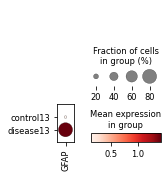

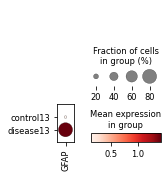

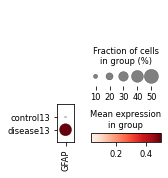

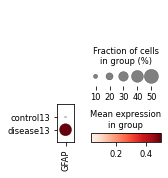

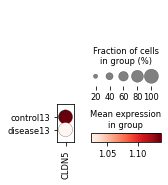

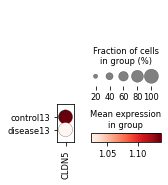

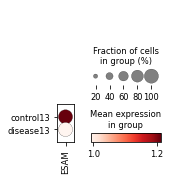

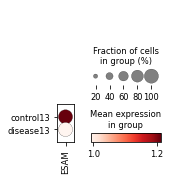

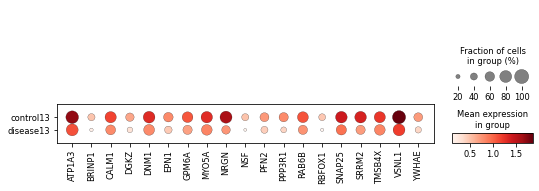

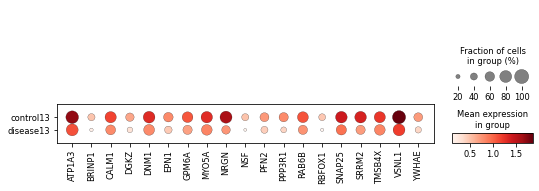

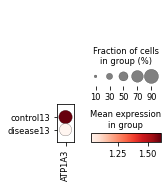

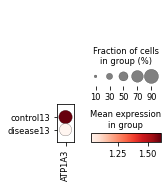

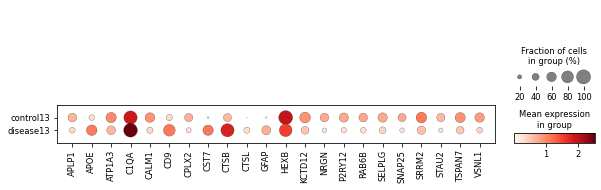

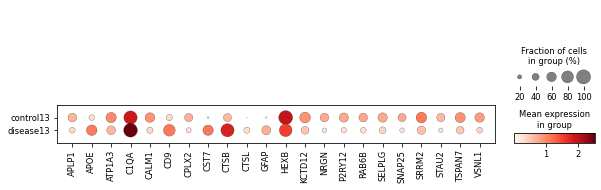

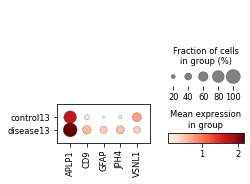

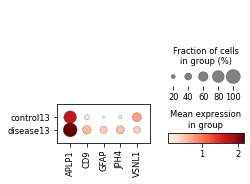

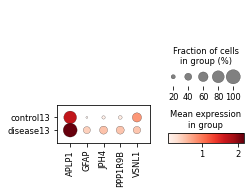

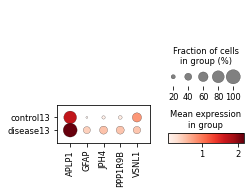

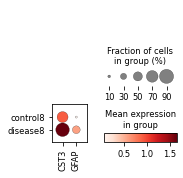

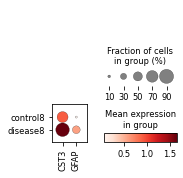

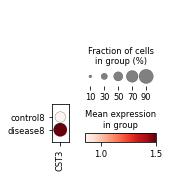

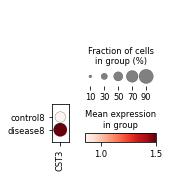

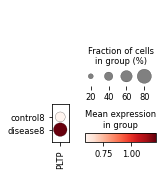

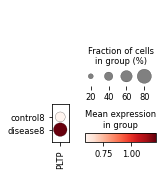

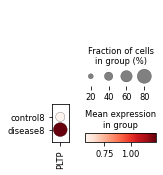

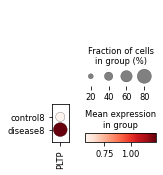

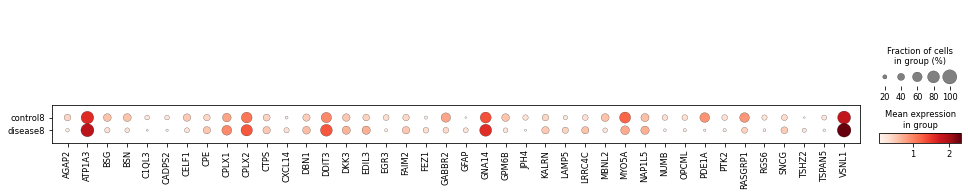

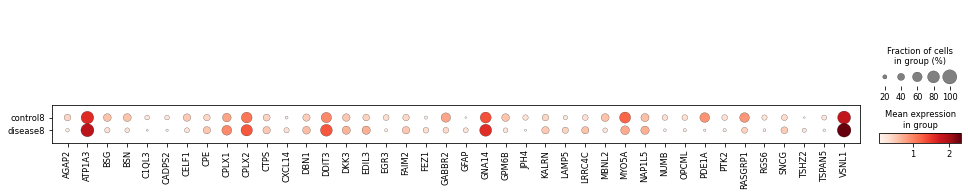

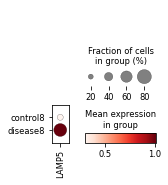

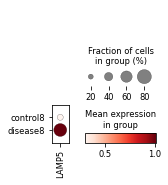

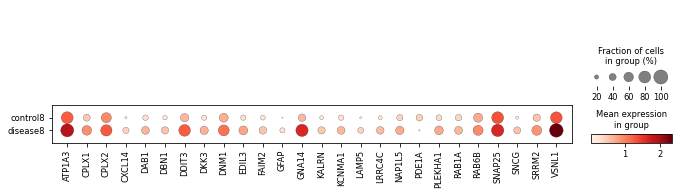

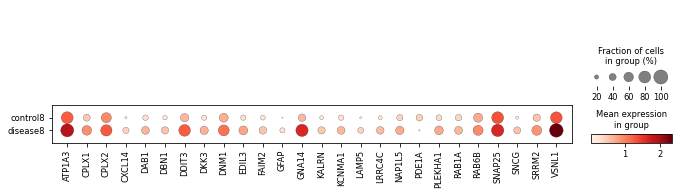

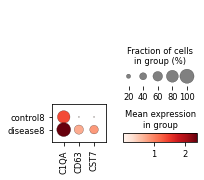

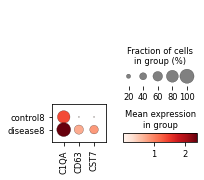

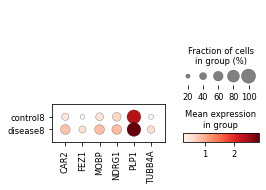

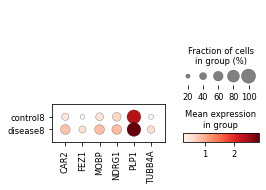

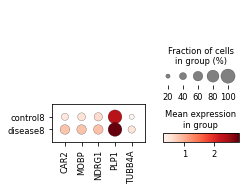

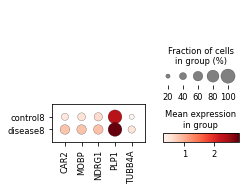

In [71]:
#pie charts by subtypes -- DE; combine clusters
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.8}#cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':6.5,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.5} #label3
# piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50,'HC intensity ratio':0.85} #label4

piechartcutoffskeys=['log avg grad','HC intensity ratio']
# xpos=[1,0]
# ypos=[1,0]
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])

DEpairs={'13':['control13','disease13'],'8':['control8','disease8']}
minCellsDE=10

def plotLoss_gradPlots_pie_byct(feature_disease,feature_control,ctnp_all_disease,ctnp_sub_all_disease,ctnp_all_control,ctnp_sub_all_control,name,plotsavepath,savenameAdd=''):
    resplot_all_disease=None
    resplot_all_control=None
    for c in plotclusters:
        if resplot_all_control is None:
            resplot_all_disease=np.copy(res['disease'+s][c])
            resplot_all_control=np.copy(res['control'+s][c])
        else:
            resplot_all_disease=np.vstack((resplot_all_disease,np.copy(res['disease'+s][c])))
            resplot_all_control=np.vstack((resplot_all_control,np.copy(res['control'+s][c])))
    resplot_all_disease[:,0]=np.log(resplot_all_disease[:,0]+0.5)
    resplot_all_control[:,0]=np.log(resplot_all_control[:,0]+0.5)
    
    for ctbroad in range(np.unique(celltype_broad).size):
        currBroad=np.unique(celltype_broad)[ctbroad]
#         if currBroad != 'Micro':
#             continue
        ctbroadIdx_disease=ctnp_all_disease==currBroad
        ctbroadIdx_control=ctnp_all_control==currBroad
        resplot_disease=resplot_all_disease[ctbroadIdx_disease]
        resplot_control=resplot_all_control[ctbroadIdx_control]
        feature_disease_ct=feature_disease[ctbroadIdx_disease]
        feature_control_ct=feature_control[ctbroadIdx_control]
        ctnp_disease=ctnp_sub_all_disease[ctbroadIdx_disease]
        ctnp_control=ctnp_sub_all_control[ctbroadIdx_control]
        print(np.sum(ctbroadIdx_disease))
#         ctnp=np.repeat('SMC',np.sum(ctbroadIdx))
        allcolors=sns.color_palette("tab10",np.unique(ctnp_disease).size)
        
        for x in range(len(piechartcutoffskeys)-1):
            xname=piechartcutoffskeys[x]
            for y in range(x+1,len(piechartcutoffskeys)):
                yname=piechartcutoffskeys[y]

                #disease upper right
                xposIdx_disease=resplot_disease[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                yposIdx_disease=resplot_disease[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                cidx_disease=np.logical_and(xposIdx_disease,yposIdx_disease)
                
                #control lower left
                xposIdx_control=resplot_control[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                yposIdx_control=resplot_control[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                cidx_control=np.logical_and(xposIdx_control,yposIdx_control)
                
#                 print(np.sum(cidx_disease))
#                 print(np.sum(cidx_control))
                if np.sum(cidx_disease)<minCellsDE or np.sum(cidx_control)<minCellsDE:
                    print(s+c)
                    print(currBroad)
                    print(np.sum(cidx_disease))
                    print(np.sum(cidx_control))
                    continue
                    
                desavedir=os.path.join(plotsavepath,s+xname+'_'+yname+'DE_'+currBroad)
                if not os.path.exists(desavedir):
                    os.mkdir(desavedir)
                #DE - major cell type
                de_singlesample(np.vstack((feature_disease_ct[cidx_disease],feature_control_ct[cidx_control])),np.concatenate((np.repeat('disease'+s,np.sum(cidx_disease)),np.repeat('control'+s,np.sum(cidx_control)))),os.path.join(desavedir,'all'),feature_names_full,False)
                
                #DE - sub cell type
                ctnp_i_disease=ctnp_disease[cidx_disease]
                ctnp_i_control=ctnp_control[cidx_control]
                for ct in range(np.unique(ctnp_disease).size):
                    currct=np.unique(ctnp_disease)[ct]
                    curridx_disease=(ctnp_i_disease==currct).flatten()
                    curridx_control=(ctnp_i_control==currct).flatten()
                    if np.sum(curridx_disease)<minCellsDE or np.sum(curridx_control)<minCellsDE:
                        continue
#                     print(feature_disease_ct[cidx_disease].shape)
#                     print(curridx_disease.shape)
                    feature_disease_sub=feature_disease_ct[cidx_disease][curridx_disease]
                    feature_control_sub=feature_control_ct[cidx_control][curridx_control]
                    
                    de_singlesample(np.vstack((feature_disease_sub,feature_control_sub)),np.concatenate((np.repeat('disease'+s,np.sum(curridx_disease)),np.repeat('control'+s,np.sum(curridx_control)))),os.path.join(desavedir,currct),feature_names_full,False)

        
for s in DEpairs.keys():
#     if 'disease' in s:
#         continue
    print(s)
    
    cname=''
    cidx_disease=np.array([])
    cidx_control=np.array([])
    for c in plotclusters:
        print(c)
        cname+=c
        cidx_disease_c=gaeclusterlabels[sampleNames=='disease'+s]==c
        cidx_disease_c=np.logical_and(cidx_disease_c,np.sum(stats3d['disease'+s],axis=1)>0)
        cidx_control_c=gaeclusterlabels[sampleNames=='control'+s]==c
        cidx_control_c=np.logical_and(cidx_control_c,np.sum(stats3d['control'+s],axis=1)>0)
        cidx_disease=np.concatenate((cidx_disease,np.arange(np.sum(sampleNames=='disease'+s))[cidx_disease_c]))
        cidx_control=np.concatenate((cidx_control,np.arange(np.sum(sampleNames=='control'+s))[cidx_control_c]))
    if cidx_disease.size>0 and cidx_control.size>0:
        if not os.path.exists(os.path.join(plotsavepath,cname)):
            os.mkdir(os.path.join(plotsavepath,cname))
        cidx_disease=cidx_disease.astype(int)
        cidx_control=cidx_control.astype(int)
        allCTnp_disease=celltype_broad[sampleNames=='disease'+s][cidx_disease]
        allCTsubnp_disease=celltype_sub[sampleNames=='disease'+s][cidx_disease]
        allCTnp_control=celltype_broad[sampleNames=='control'+s][cidx_control]
        allCTsubnp_control=celltype_sub[sampleNames=='control'+s][cidx_control]
        feature_disease=np.copy(featureslist_full['disease'+s])[cidx_disease]
        feature_control=np.copy(featureslist_full['control'+s])[cidx_control]
        plotLoss_gradPlots_pie_byct(feature_disease,feature_control,allCTnp_disease,allCTsubnp_disease,allCTnp_control,allCTsubnp_control,'all',os.path.join(plotsavepath,cname),plotepoch)


In [69]:
cidx_disease

array([5924., 5942., 5947., ..., 9221., 9228., 9253.])

disease13
0
78
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease13log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
0
0
0
81
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease13log avg grad_dapiDE_Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


755
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease13log avg grad_dapiDE_Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


128
0
96
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease13log avg grad_dapiDE_Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


18
88
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease13log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


39
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease13log avg grad_dapiDE_SMC
1
108
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease13log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
0
1
10
107
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease13log avg grad_dapiDE_Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


484
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease13log avg grad_dapiDE_Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


86
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease13log avg grad_dapiDE_Inhi
0
157
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease13log avg grad_dapiDE_Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


22
234
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease13log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


38
2
46
1
1
1
1683
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/2/disease13log avg grad_dapiDE_DG


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


12
12
27
0
22
3
43
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/2/disease13log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


6
3
75
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease13log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
0
1
1
40
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease13log avg grad_dapiDE_Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


639
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease13log avg grad_dapiDE_Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_utils.py:1138: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see 

43
0
89
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease13log avg grad_dapiDE_Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


15
256
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease13log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


18
4
411
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease13log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


4
1
39
12
209
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease13log avg grad_dapiDE_Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


12
122
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease13log avg grad_dapiDE_Inhi


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


13
272
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease13log avg grad_dapiDE_Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


75
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease13log avg grad_dapiDE_OPC


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


189
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease13log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


116
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease13log avg grad_dapiDE_SMC
5
150
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease13log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
0
0
0
47
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease13log avg grad_dapiDE_Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2
18
0
138
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease13log avg grad_dapiDE_Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


40
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease13log avg grad_dapiDE_OPC


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


857
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease13log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


47
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease13log avg grad_dapiDE_SMC


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


6
34
796
16
13
2
31
11
29
0
24
2
11
5
7
34
7
70
470
0
20
16
19
0
17
9
44
3
8
disease8
0
67
2
0
3
2
57
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease8log avg grad_dapiDE_Endo
908
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease8log avg grad_dapiDE_Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


134
0
92
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/disease8log avg grad_dapiDE_Micro
16
52
15
1
130
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease8log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
0
0
0
100
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease8log avg grad_dapiDE_Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


903
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease8log avg grad_dapiDE_Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: Implic

144
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease8log avg grad_dapiDE_Inhi


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
115
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease8log avg grad_dapiDE_Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


32
200
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/1/disease8log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


47
2
10
0
0
10
366
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/2/disease8log avg grad_dapiDE_DG


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


5
23
14
1
4
2
5
0
3
61
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease8log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


1
0
2
1
52
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease8log avg grad_dapiDE_Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


655
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease8log avg grad_dapiDE_Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


66
0
65
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease8log avg grad_dapiDE_Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


15
205
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/3/disease8log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


14
4
203
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease8log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


7
3
14
18
88
8
85
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/4/disease8log avg grad_dapiDE_Inhi


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


8
91
29
89
58
5
81
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease8log avg grad_dapiDE_Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
0
0
0
13
1
12
0
32
19
435
/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/5/disease8log avg grad_dapiDE_Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


21
6
14
562
17
12
2
8
10
26
0
7
1
4
4
7
25
24
110
428
0
16
23
23
0
11
2
15
2
8


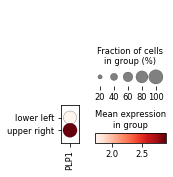

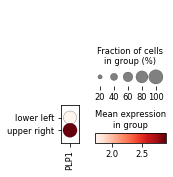

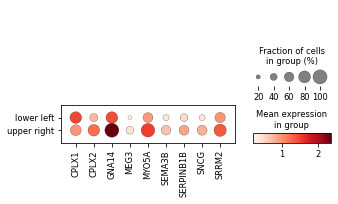

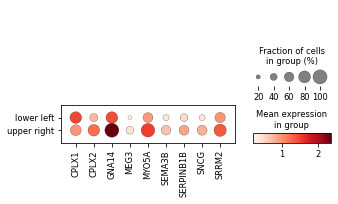

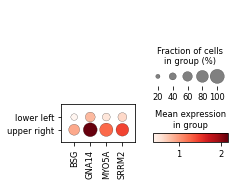

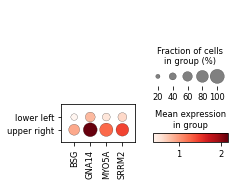

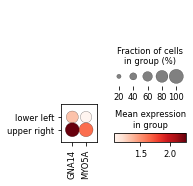

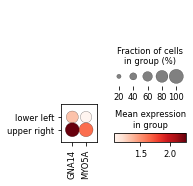

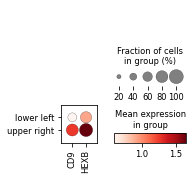

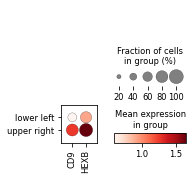

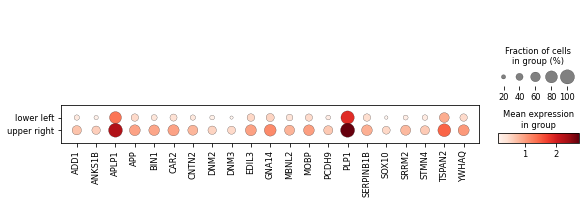

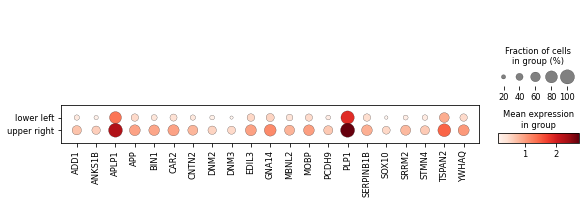

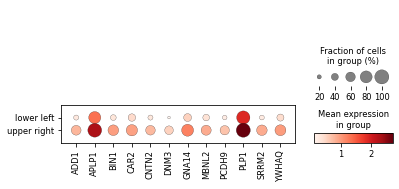

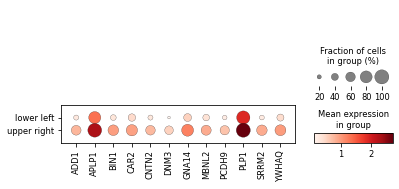

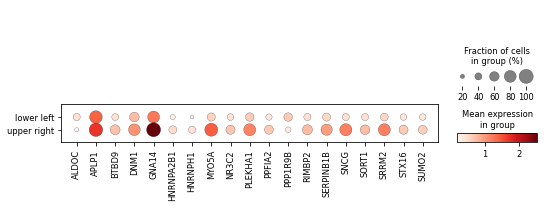

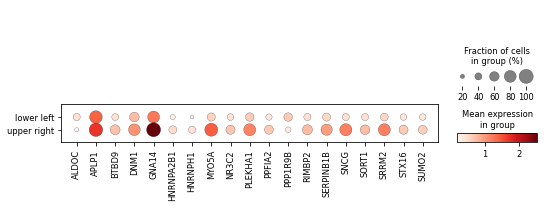

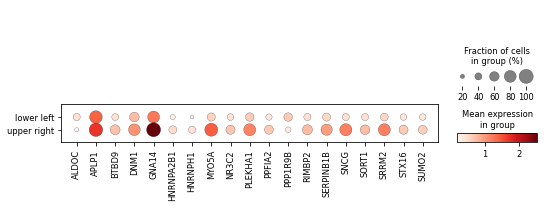

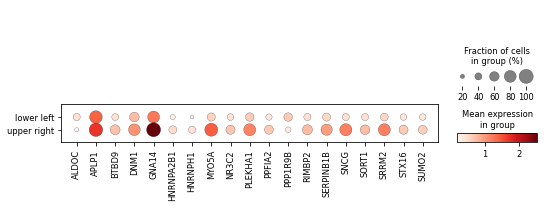

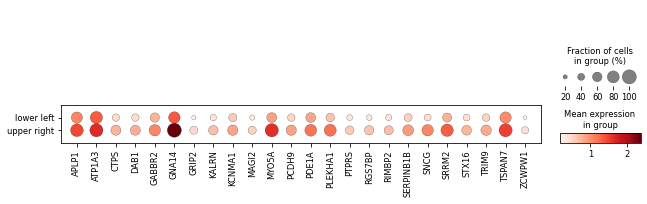

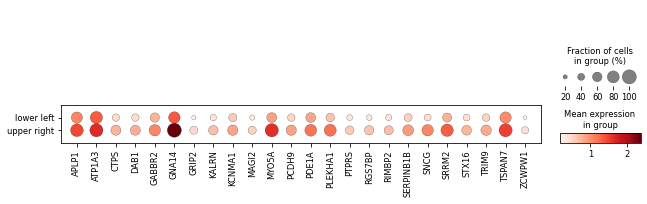

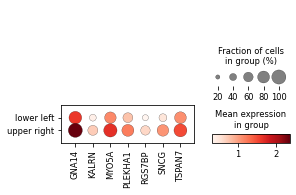

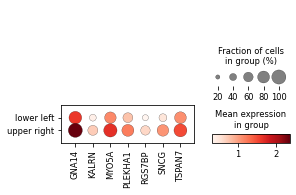

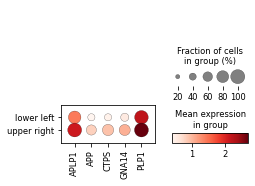

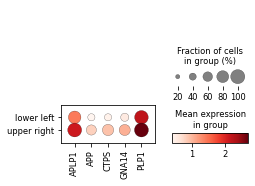

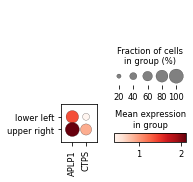

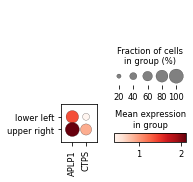

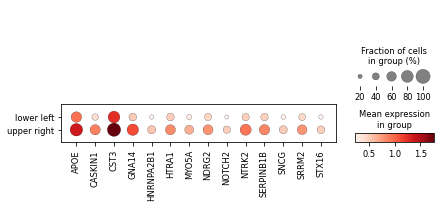

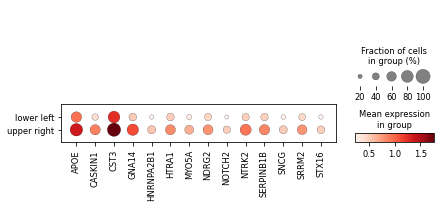

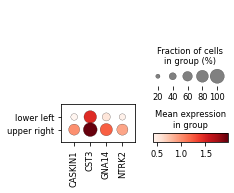

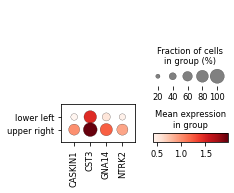

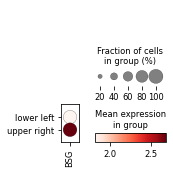

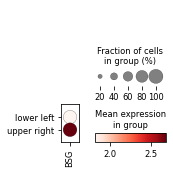

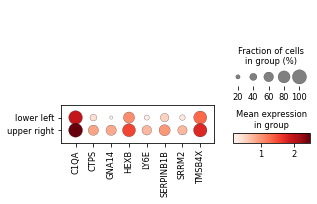

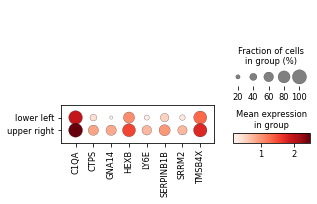

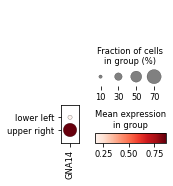

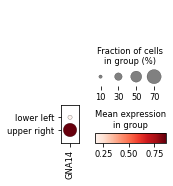

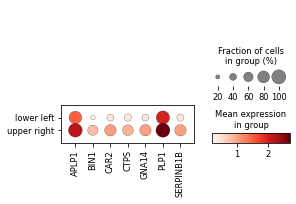

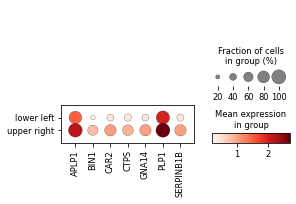

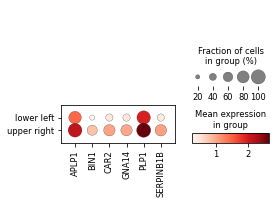

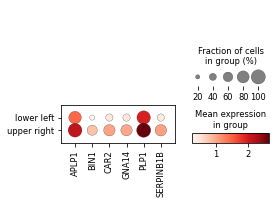

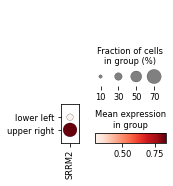

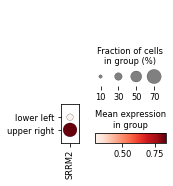

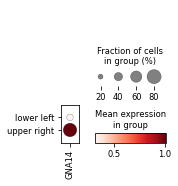

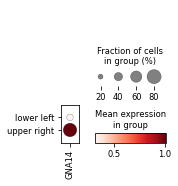

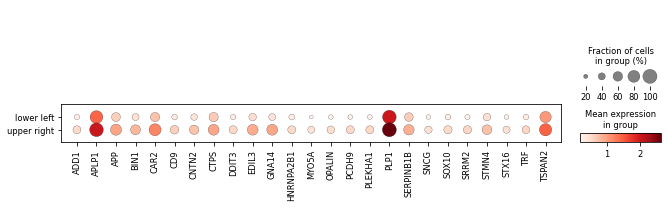

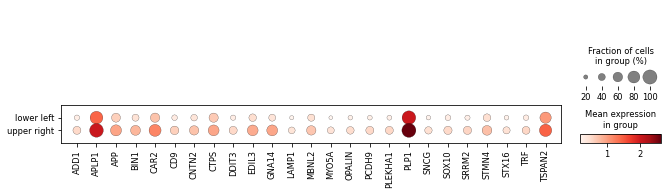

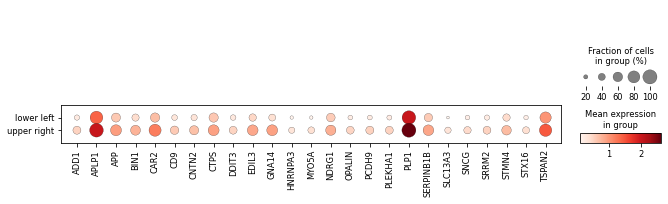

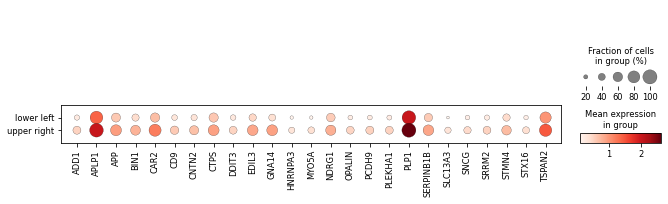

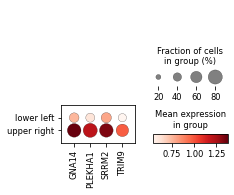

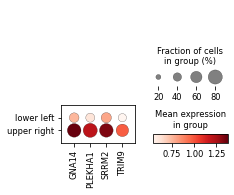

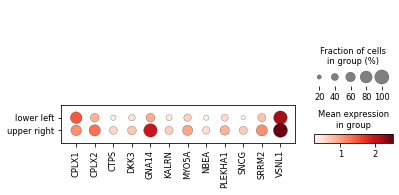

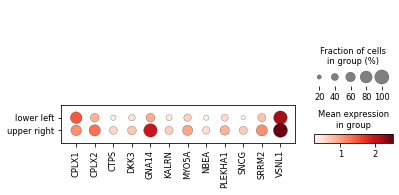

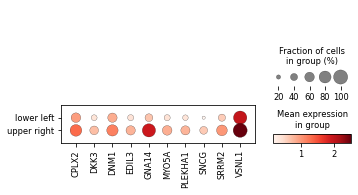

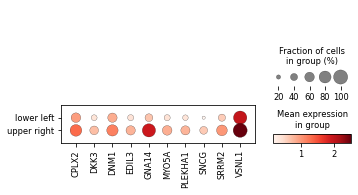

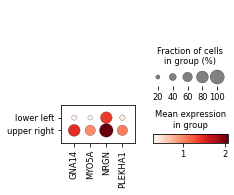

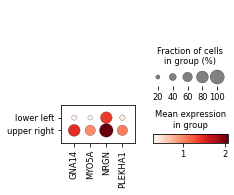

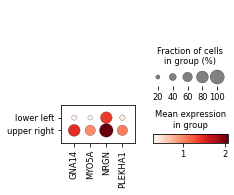

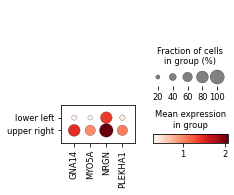

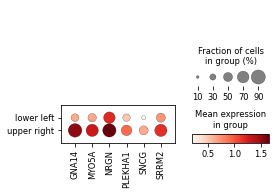

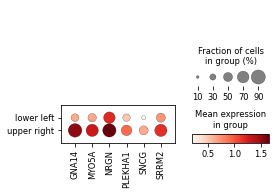

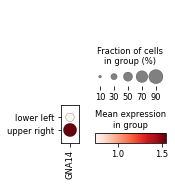

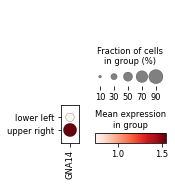

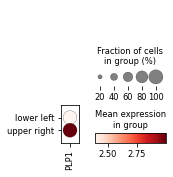

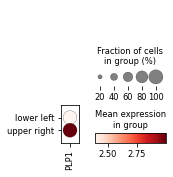

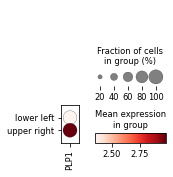

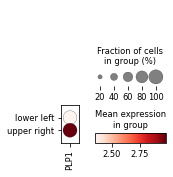

In [74]:
#pie charts by subtypes -- DE wihtin disease
# piechartcutoffs={'log avg grad':5.5,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01
# piechartcutoffs={'log avg grad':7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster013_seed15

#thresholds after fixed missing modelcnn.eval
piechartcutoffs={'log avg grad':6.7,'dapi':0.2,'log plaque':-50} #cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01

piechartcutoffskeys=['log avg grad','dapi']
# xpos=[1,0]
# ypos=[1,0]
xpos=[0,1]
ypos=[0,1]
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM'])

DEpairs={'disease13':['disease13'],'disease8':['disease8']}
minCellsDE=10

def plotLoss_gradPlots_pie_byct_inonesample(feature_disease,ctnp_all_disease,ctnp_sub_all_disease,name,plotsavepath,savenameAdd=''):
    resplot_all_disease=np.copy(res[s][c])
    resplot_all_disease[:,0]=np.log(resplot_all_disease[:,0]+0.5)
    
    for ctbroad in range(np.unique(celltype_broad).size):
        currBroad=np.unique(celltype_broad)[ctbroad]
#         if currBroad != 'SMC':
#             continue
        ctbroadIdx_disease=ctnp_all_disease==currBroad
        resplot_disease=resplot_all_disease[ctbroadIdx_disease]
        feature_disease_ct=feature_disease[ctbroadIdx_disease]
        ctnp_disease=ctnp_sub_all_disease[ctbroadIdx_disease]
        print(np.sum(ctbroadIdx_disease))
#         ctnp=np.repeat('SMC',np.sum(ctbroadIdx))
        allcolors=sns.color_palette("tab10",np.unique(ctnp_disease).size)
        
        for x in range(len(piechartcutoffskeys)-1):
            xname=piechartcutoffskeys[x]
            for y in range(x+1,len(piechartcutoffskeys)):
                yname=piechartcutoffskeys[y]

                #disease upper right
                xposIdx_disease=resplot_disease[:,np.where(colnamesloggrad==xname)].flatten()>=piechartcutoffs[xname]
                yposIdx_disease=resplot_disease[:,np.where(colnamesloggrad==yname)].flatten()>=piechartcutoffs[yname]
                cidx_disease=np.logical_and(xposIdx_disease,yposIdx_disease)
                
                #disease lower left
                xposIdx_diseaseLL=resplot_disease[:,np.where(colnamesloggrad==xname)].flatten()<piechartcutoffs[xname]
                yposIdx_diseaseLL=resplot_disease[:,np.where(colnamesloggrad==yname)].flatten()<piechartcutoffs[yname]
                cidx_diseaseLL=np.logical_and(xposIdx_diseaseLL,yposIdx_diseaseLL)
                
#                 print(np.sum(cidx_disease))
#                 print(np.sum(cidx_control))
                if np.sum(cidx_disease)<minCellsDE or np.sum(cidx_diseaseLL)<minCellsDE:
                    continue
                    
                desavedir=os.path.join(plotsavepath,s+xname+'_'+yname+'DE_'+currBroad)
                print(desavedir)
                if not os.path.exists(desavedir):
                    os.mkdir(desavedir)
                #DE - major cell type
                de_singlesample(np.vstack((feature_disease_ct[cidx_disease],feature_disease_ct[cidx_diseaseLL])),np.concatenate((np.repeat('upper right',np.sum(cidx_disease)),np.repeat('lower left',np.sum(cidx_diseaseLL)))),os.path.join(desavedir,'all'),feature_names_full,False)
                
                #DE - sub cell type
                ctnp_i_disease=ctnp_disease[cidx_disease]
                ctnp_i_diseaseLL=ctnp_disease[cidx_diseaseLL]
                for ct in range(np.unique(ctnp_disease).size):
                    currct=np.unique(ctnp_disease)[ct]
                    curridx_disease=(ctnp_i_disease==currct).flatten()
                    curridx_diseaseLL=(ctnp_i_diseaseLL==currct).flatten()
                    if np.sum(curridx_disease)<minCellsDE or np.sum(curridx_diseaseLL)<minCellsDE:
                        continue
#                     print(feature_disease_ct[cidx_disease].shape)
#                     print(curridx_disease.shape)
                    feature_disease_sub=feature_disease_ct[cidx_disease][curridx_disease]
                    feature_diseaseLL_sub=feature_disease_ct[cidx_diseaseLL][curridx_diseaseLL]
                    
                    de_singlesample(np.vstack((feature_disease_sub,feature_diseaseLL_sub)),np.concatenate((np.repeat('upper right',np.sum(curridx_disease)),np.repeat('lower left',np.sum(curridx_diseaseLL)))),os.path.join(desavedir,currct),feature_names_full,False)

        
for s in DEpairs.keys():
#     if 'disease' in s:
#         continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx_disease=gaeclusterlabels[sampleNames==s]==c
        if np.sum(cidx_disease)>0:
            allCTnp_disease=celltype_broad[sampleNames==s][cidx_disease]
            allCTsubnp_disease=celltype_sub[sampleNames==s][cidx_disease]
            feature_disease=np.copy(featureslist_full[s])[cidx_disease]
            plotLoss_gradPlots_pie_byct_inonesample(feature_disease,allCTnp_disease,allCTsubnp_disease,'all',os.path.join(plotsavepath,str(c)),plotepoch)


In [29]:
os.path.exists('/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01/allk20XA_02_dca_over_leiden0.1_epoch9990/0/13log avg grad_dapiDE_Astro')

True

In [32]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

disease13
0
3
1


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


control13
0
3
1
disease8
0
3
1
control8
0
3
1


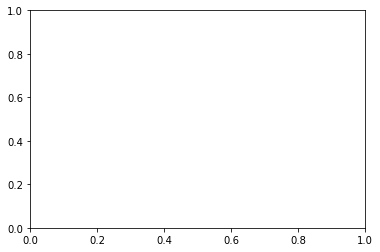

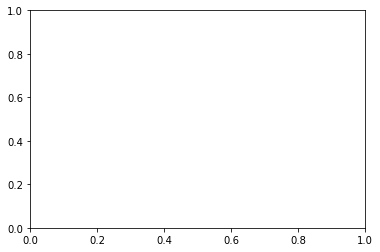

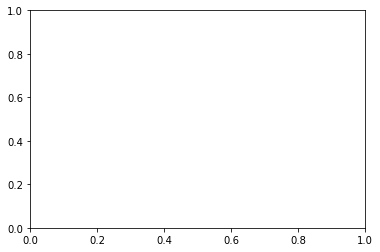

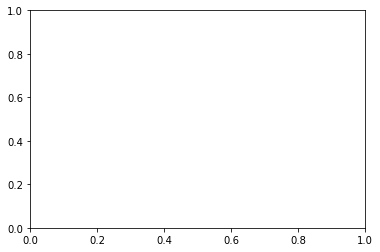

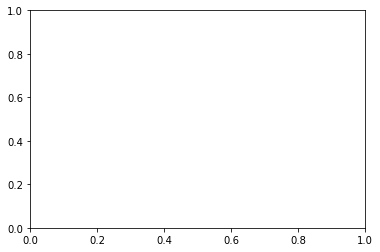

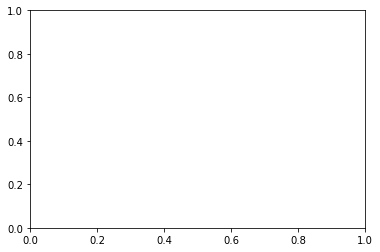

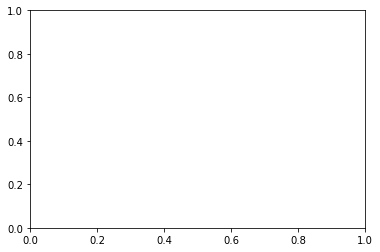

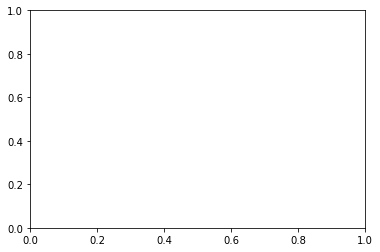

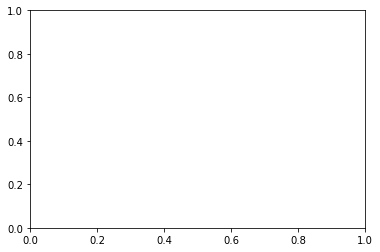

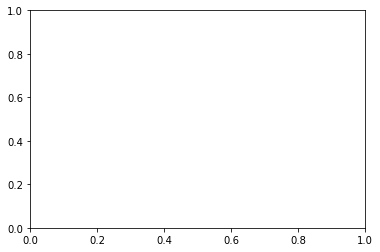

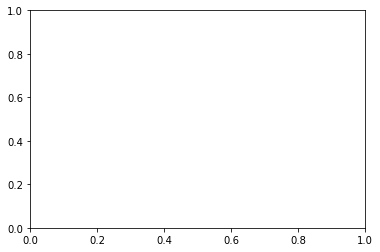

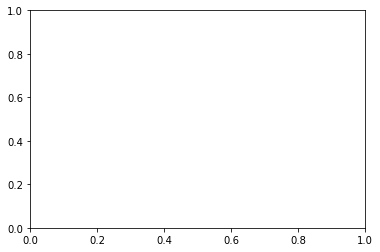

In [34]:
#regrs on secM_noAPP and log avg grad by ct in each  cluster
np.random.seed(seed)
colnamesloggrad=np.array(['log avg grad','pred size','log plaque','dapi','secM_noAPP','label','mean intensity', 'area','standard_deviation_intensity','mean_max_distance_to_centroid_ratio','avg dist to 20 NN','HC ratio','avg dist to 3 NN','pixelVariance','HC intensity ratio'])
valgradthresh=4

allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
def plotLoss_gradRegrs(ctnp,name,plotsavepath,savenameAdd=''):
    fig, ax = plt.subplots()
    for ct in range(np.unique(celltype_broad).size):
        curridx=ctnp==np.unique(celltype_broad)[ct]
        if np.sum(curridx)==0:
            continue
        plotx=np.log(res[s][c][curridx,x]+0.5)
        plotidx=plotx>valgradthresh
        regrs_res=linregress(plotx[plotidx],res[s][c][curridx,y][plotidx])
        regrs_slope[ci,ct]=regrs_res.slope
        regrs_pval[ci,ct]=regrs_res.pvalue
    
            
for s in plot_samples.keys():
#     if 'control' in s:
#         continue
    print(s)
    x=0
    y=-1
    regrs_slope=np.zeros((len(plotclusters),np.unique(celltype_broad).size))
    regrs_pval=np.zeros((len(plotclusters),np.unique(celltype_broad).size))+1
    for ci in range(len(plotclusters)):
        c=['0','3','1'][ci]
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        cidx=np.logical_and(cidx,np.sum(stats3d[s],axis=1)>0)
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_gradRegrs(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)

    fig, ax = plt.subplots()
    im = ax.imshow(regrs_slope)
    ax.set_xticks(np.arange(regrs_slope.shape[1]))
    ax.set_yticks(np.arange(regrs_slope.shape[0]))
    ax.set_xticklabels(np.unique(celltype_broad))
#     ax.set_yticklabels(plotclusters)
    ax.set_yticklabels(['1','2','3'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    regrs_pval=np.round_(regrs_pval,3)
    for i in range(regrs_slope.shape[0]):
        for j in range(regrs_slope.shape[1]):
            if regrs_pval[i, j]>0.05 or (not np.isfinite(regrs_pval[i, j])):
                text = ax.text(j, i, regrs_pval[i, j],ha="center", va="center", color="black",fontsize=5)
            else:
                text = ax.text(j, i, regrs_pval[i, j],ha="center", va="center", color="red",fontsize=5)
#     plt.grid(None) 
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(im, cax = cax)
#     cbar = ax.figure.colorbar(im, ax=ax)
#         cbar.ax.set_ylabel(rotation=-90, va="bottom")
    plt.savefig(os.path.join(plotsavepath,s+'logavggradRegrs_'+colnamesloggrad[y]+'_removeOutlier.jpg'),dpi=400)
    plt.close()

In [21]:
plotclusters

['0', '1', '3']

In [141]:
np.random.seed(seed)
colnames=['avg grad','pred size','log plaque','dapi','secM']
allcolors=sns.color_palette("tab20",np.unique(celltype_broad).size)
pca=PCA()
def plotLoss_pcaPlots(ctnp,name,plotsavepath,savenameAdd=''):
    resplot=res[s][c]
    for i in range(resplot.shape[1]):
        resplot[:,i]=(resplot[:,i]-np.min(resplot[:,i]))/(np.max(resplot[:,i])-np.min(resplot[:,i]))
    pca.fit(resplot)
    pca_values=pca.components_
    xtrans=pca.transform(resplot)
    for x in range(len(colnames)-1):
        for y in range(x+1,len(colnames)):
            fig, ax = plt.subplots()
            for i in range(len(pca_values[0])):
                xi=pca_values[x][i]
                yi=pca_values[y][i]
                plt.arrow(0,0, 
                          dx=xi, dy=yi, 
                          head_width=0.03, head_length=0.03, 
                          color='black', length_includes_head=True)
                plt.text(xi, 
                         yi, 
                         s=colnames[i],fontsize='small' )
            for ct in range(np.unique(celltype_broad).size):
                curridx=ctnp==np.unique(celltype_broad)[ct]
                if np.sum(curridx)==0:
                    continue
                ax.scatter(xtrans[curridx,x],xtrans[curridx,y],color=allcolors[ct],s=1,label=np.unique(celltype_broad)[ct])
            ax.legend()
            ax.set_xlabel('pc'+str(x))
            ax.set_ylabel('pc'+str(y))
            plt.savefig(os.path.join(plotsavepath,s+'pc'+str(x)+'_'+'pc'+str(y)+'.jpg'),dpi=400)
            plt.close()
        
for s in plot_samples.keys():
    if 'control' in s:
        continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            plotLoss_pcaPlots(allCTnp,'all',os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
1
2
3
4
5
6
7
8
disease8
0
1
2
3
4
5
6
7
8


In [142]:
np.random.seed(seed)
def plotLoss_secMheatmap(features,ctname,plotsavepath,savenameAdd=''):
#     heatmap=features*np.repeat(np.array((secM-np.min(secM))/(np.max(secM)-np.min(secM))).reshape((1,-1)),features.shape[0],axis=0)
#     print(features.shape)
    heatmap=pd.DataFrame(features,columns=feature_names)
    print(heatmap.shape)
    heatmap=sns.clustermap(heatmap)
#     heatmap=heatmap.fig
    heatmap.savefig(os.path.join(plotsavepath,s+'secM'+ctname+'.jpg'),dpi=400)
    plt.close()
        
for s in plot_samples.keys():
    if 'control' in s:
        continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            features_c=featureslist[s][cidx]
            for ct in np.unique(allCTnp):
                ctidx=allCTnp==ct
                if(np.sum(ctidx)<2):
                    continue
                features_ct=features_c[ctidx]
                plotLoss_secMheatmap(features_ct,ct,os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0
(78, 512)


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


(81, 512)
(755, 512)
(128, 512)
(96, 512)
(18, 512)
(88, 512)
(39, 512)
1
(108, 512)
(10, 512)
(107, 512)
(484, 512)
(86, 512)
(157, 512)
(22, 512)
(234, 512)
(38, 512)
2
(46, 512)
(1683, 512)
(12, 512)
(12, 512)
(27, 512)
(22, 512)
(3, 512)
(43, 512)
(6, 512)
3
(75, 512)
(40, 512)
(639, 512)
(43, 512)
(89, 512)
(15, 512)
(256, 512)
(18, 512)
4
(411, 512)
(4, 512)
(39, 512)
(12, 512)
(209, 512)
(12, 512)
(122, 512)
(13, 512)
(272, 512)
(75, 512)
(189, 512)
(116, 512)
5
(150, 512)
(47, 512)
(2, 512)
(18, 512)
(138, 512)
(40, 512)
(857, 512)
(47, 512)
6
(34, 512)
(796, 512)
(16, 512)
(13, 512)
(2, 512)
(31, 512)
(11, 512)
(29, 512)
(24, 512)
(2, 512)
(11, 512)
(5, 512)
7
(34, 512)
(7, 512)
(70, 512)
(470, 512)
(20, 512)
(16, 512)
(19, 512)
(17, 512)
(9, 512)
(44, 512)
(3, 512)
8
disease8
0
(67, 512)
(2, 512)
(3, 512)
(2, 512)
(57, 512)
(908, 512)
(134, 512)
(92, 512)
(16, 512)
(52, 512)
(15, 512)
1
(130, 512)
(100, 512)
(903, 512)
(144, 512)
(115, 512)
(32, 512)
(200, 512)
(47, 512)
2
(1

In [36]:
np.repeat(np.array(secM).reshape((1,-1)),2,axis=0)

array([[2.57740132e-04, 7.59990425e-05, 2.11419604e-03, ...,
        9.34000678e-03, 6.88336232e-05, 2.18960231e-03],
       [2.57740132e-04, 7.59990425e-05, 2.11419604e-03, ...,
        9.34000678e-03, 6.88336232e-05, 2.18960231e-03]])

In [145]:
np.random.seed(seed)
def plotLoss_secMheatmap_componentscore(features,ctname,plotsavepath,savenameAdd=''):
#     heatmap=features*np.repeat(np.array((secM-np.min(secM))/(np.max(secM)-np.min(secM))).reshape((1,-1)),features.shape[0],axis=0)
#     print(features.shape)
    heatmap=pd.DataFrame(features*np.repeat(np.array(secM).reshape((1,-1)),features.shape[0],axis=0),columns=feature_names)
#     print(np.array(heatmap)[:10,:10])
    heatmap=sns.clustermap(heatmap)
#     heatmap=heatmap.fig
    heatmap.savefig(os.path.join(plotsavepath,s+'secM'+ctname+'_weighted.jpg'),dpi=400)
    plt.close()
        
for s in plot_samples.keys():
    if 'control' in s:
        continue
    print(s)
    
    for c in np.unique(gaeclusterlabels):
        print(c)
        cidx=gaeclusterlabels[sampleNames==s]==c
        
        if np.sum(cidx)>0:
            allCTnp=celltype_broad[sampleNames==s][cidx]
            features_c=featureslist[s][cidx]
            for ct in np.unique(allCTnp):
                ctidx=allCTnp==ct
                if(np.sum(ctidx)<2):
                    continue
                features_ct=features_c[ctidx]
                plotLoss_secMheatmap_componentscore(features_ct,ct,os.path.join(plotsavepath,str(c)),plotepoch)


disease13
0


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


1
2
3
4
5
6
7
8
disease8
0
1
2
3
4
5
6
7
8


(array([250., 124.,  67.,  33.,  20.,  11.,   4.,   1.,   0.,   1.]),
 array([9.320000e-07, 2.477890e-04, 4.946460e-04, 7.415030e-04,
        9.883600e-04, 1.235217e-03, 1.482074e-03, 1.728931e-03,
        1.975788e-03, 2.222645e-03, 2.469502e-03]),
 <BarContainer object of 10 artists>)

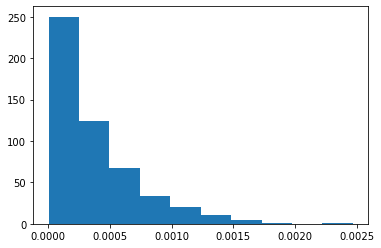

In [78]:
plt.hist(secM[secM<0.15])

In [79]:
secM[secM<0.15]

,secretory support component score
geneSymbol,
ABHD6,0.000040
ACBD7,0.000012
ACHE,0.000325
ACSL3,0.001226
ACSL4,0.000891
...,...
WWOX,0.000469
XBP1,0.000562
YWHAQ,0.001434


In [13]:
plaqueOrigImg=mpimg.imread(os.path.join(datadir,plot_samples[s],'trimmed_images','Maskofplaque.tif'))

In [100]:
np.unique(plaqueOrigImg)

array([  0, 255], dtype=uint8)

In [14]:
testplaquedistr=np.where(plaqueOrigImg==255)

In [15]:
coordPlaque=np.hstack((testplaquedistr[0].reshape((testplaquedistr[0].size,1)),testplaquedistr[1].reshape((testplaquedistr[1].size,1))))

In [53]:
plaqueCentroids=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/'+plot_samples[s]+'/trimmed_images/'+'PlaqueMask'+'.csv', header=0)


In [70]:
res['disease13']['0'][res['disease13']['0'][:,1]>0]

array([[ 5.22001505e+02,  8.69524707e+03,  1.19581293e-41,
         2.46922407e-01, -3.20893223e-01],
       [ 3.13408604e+02,  1.97016565e+03,  1.60018633e-34,
         8.39224536e-02, -9.49834940e-02],
       [ 3.85877687e+02,  1.83642334e+03,  1.27568324e-26,
         2.56257139e-01, -2.93268244e-01],
       ...,
       [ 1.41200942e+02,  6.13436914e+03,  6.66312474e-62,
         1.37844037e-01, -3.23018340e-01],
       [ 3.53493760e+02,  9.06451074e+03,  8.20924214e-26,
         1.33547911e-01, -3.11227852e-01],
       [ 2.41561469e+02,  2.97417944e+03,  7.49449507e-84,
         1.61319052e-01, -2.50034319e-01]])

In [124]:
np.repeat(np.arange(4).reshape((1,-1)),3,axis=0)

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])